In [1]:
from src.regions import *
from src.run import *
from src.test import *
from src.degree_strength import *
from src.visualization.visual import *
from src.parser import *
import numpy as np
import pandas as pd
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from src.visualization.visual import *
from src.batches import *
from src.fmri import *
from notebooks import *

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Preprocessed and filtered subjects with two time points
features_0 = pd.read_csv('../data/processed/features_0.csv')
features_1 = pd.read_csv('../data/processed/features_1.csv')

In [4]:
assert features_0.shape == features_1.shape

In [5]:
# Could be done earlier or ignored depending on the task
features_0.rename(columns={'G_lavaan.baseline': 'g_lavaan'}, inplace=True)
features_1.rename(columns={'G_lavaan.2Year': 'g_lavaan'}, inplace=True)

In [6]:
# brain parcelation .csv
regions = pd.read_csv('../data/gordon_sub_cere_parcels.csv')

In [7]:
assert regions.shape[0] == 418

In [8]:
# Test cell
subject = "NDARINVVKXBTBUE"
observation = "baselineYear1Arm1"

test_matrix = read_file_to_matrix(subject, observation, directory='../connectomes/connectomes')

assert test_matrix.shape[0] == 418

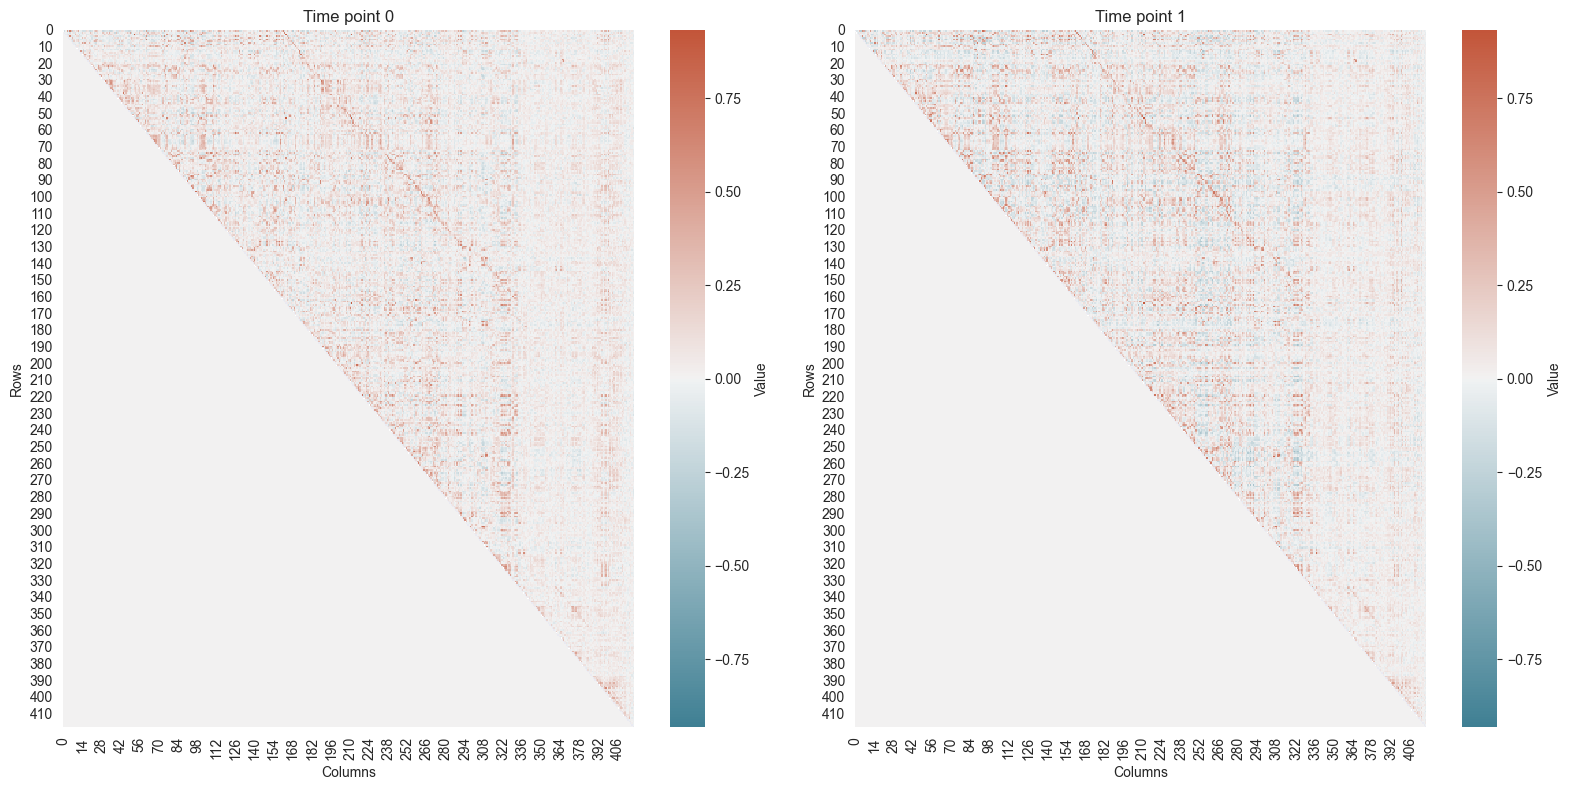

In [9]:
# Test sampler
subjects = sampler_modified(features_0, number=1)
for s in subjects:
    new_matrix_1 = convert_matrix_to_array(s[0])
    new_matrix_2 = convert_matrix_to_array(s[1])

    plot_side_by_side_heatmaps(new_matrix_1, new_matrix_2)

In [10]:
# Create a mapping from ParcelId to NetworkNumber
parcel_to_community = dict(zip(regions["ParcelID"], regions["NetworkNumber"]))

# Get the number of communities
num_communities = regions["NetworkNumber"].nunique()
community_sizes = regions["NetworkNumber"].value_counts(sort=False).sort_index().tolist()

value_counts = Counter(parcel_to_community.values())
community_sizes_ordered = []
# To print the count of keys for each value
for value, count in dict(sorted(value_counts.items())).items():
    #print(f"Value: {value} - Count of keys: {count}")
    community_sizes_ordered.append(count)
#print(community_sizes_ordered)

Saved to: edge_level.png


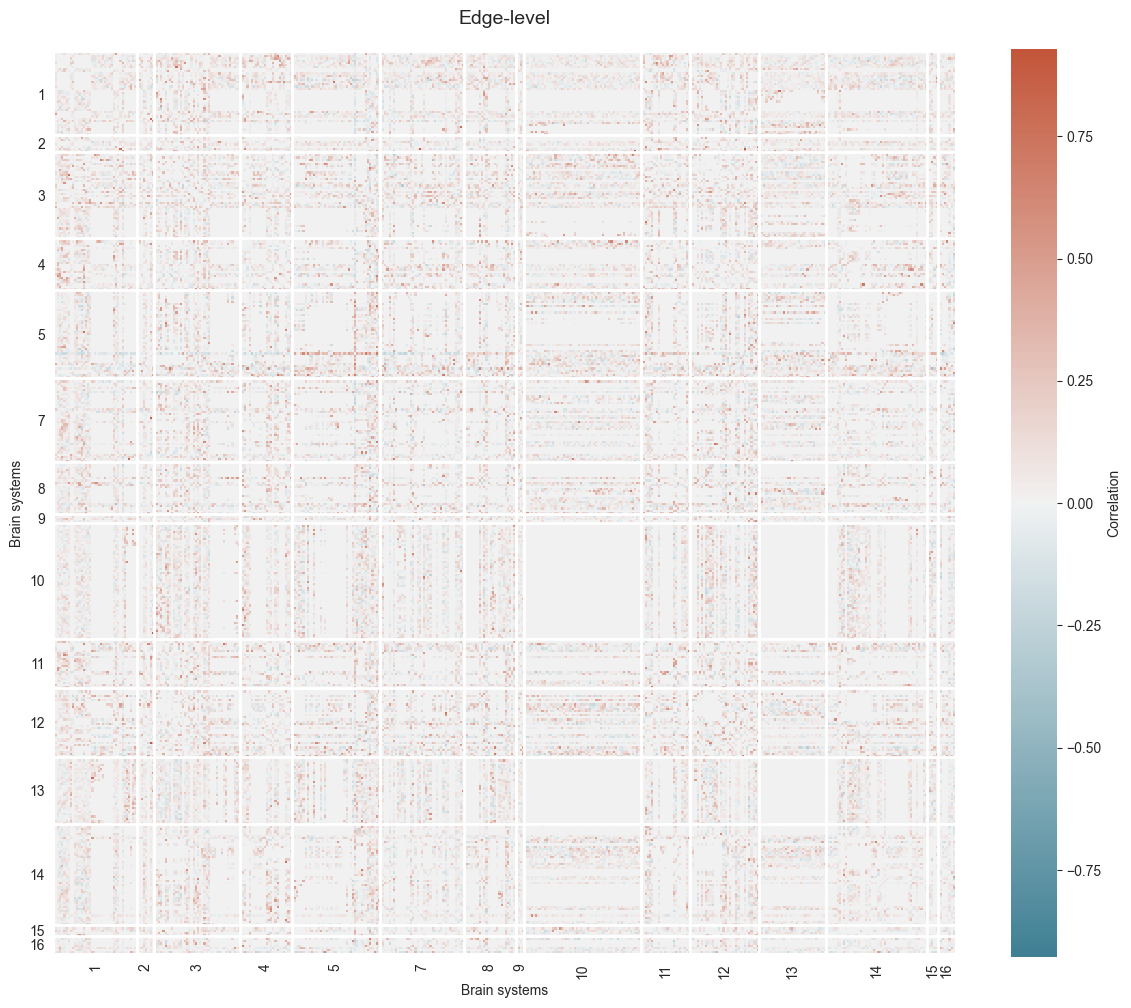

In [11]:
# test
test_symmetric_matrix, net_order, comm_sizes = process_connectivity_data(new_matrix_1, regions)
plot_network_matrix(test_symmetric_matrix, net_order, comm_sizes, save_path="edge_level.png")

In [13]:
# Functions should be moved to a corresponding folders
''' This function takes number of subjects one want to have for the future analysis and the name of data we read from
    It returns two arrays of shape number of subjects x 87153, where each line represents a flattened matrix
    and a list of subjects, where subject identifiers are stored'''

def create_pca_matrix_by_subject(number_of_subjects, data):
    observation_1 = "baselineYear1Arm1"
    observation_2 = "2YearFollowUpYArm1"

    connectomes_baseline, connectomes_followup = [], []
    subjects = []

    # Get unique subjects and shuffle them
    unique_subjects = data['Subject'].unique()
    np.random.shuffle(unique_subjects)

    count = 0
    for subject in unique_subjects:
        if count >= number_of_subjects:
            break

        # Read matrices for the subject
        matrix_1 = read_file_to_matrix(subject, observation_1, directory='../connectomes/connectomes')
        matrix_2 = read_file_to_matrix(subject, observation_2, directory='../connectomes/connectomes')

        if matrix_1 is not None and matrix_2 is not None:
            try:
                new_matrix_1 = convert_matrix_to_array(matrix_1)
                new_matrix_2 = convert_matrix_to_array(matrix_2)

                a = np.array(new_matrix_1)
                b = np.array(new_matrix_2)

                if a.shape != (418, 418) or b.shape != (418, 418):
                    raise ValueError(
                        f"Matrix shape is incorrect for subject. Expected (418, 418), got {a.shape} and {b.shape}.")

                connectomes_baseline.append(a)
                connectomes_followup.append(b)
                subjects.append(subject)
                count += 1

            except Exception as e:
                print(f"Error processing subject {subject}! {e}")
                continue

    flattened_baseline = np.array([conn[np.triu_indices(418, k=1)].flatten() for conn in connectomes_baseline])
    print(f"Shape of flattened connectomes: {flattened_baseline.shape}")

    flattened_followup = np.array([conn[np.triu_indices(418, k=1)].flatten() for conn in connectomes_followup])
    print(f"Shape of flattened connectomes: {flattened_followup.shape}")

    return flattened_baseline, flattened_followup, subjects

In [ ]:
X_baseline, X_followup, subjects = create_pca_matrix_by_subject(number_of_subjects=2480,
                                                                            data=features_0)

# Methodological replication of the "Brain-wide functional connectivity patterns support general cognitive ability and mediate effects of socioeconomic status in youth"
https://pmc.ncbi.nlm.nih.gov/articles/PMC8575890/

Can not find this exact release data version, so the full replication of the study is not possible. We can move on to the methodological replication. We will test the generalizability of the method across data versions and cohorts.
The original study used ABCD Release 2.0.1. Our analysis uses most recent release due to availability. Notable differences between these releases include initial number of subjects and the number of cohorts. Therefore, a direct replication is not possible.

## Question 1:
When we apply the authors' exact method to a different iteration of the ABCD dataset, do we get a similar result?

### Data Source and Sample:

* Original Paper's Data: ABCD Release 2.0.1
* New Sample Size: 13274 (total number of observations), 11535 (with g_score), 7674 (baseline cohort), 5600 (followup cohort)

In [14]:
# the whole available data
features = pd.read_csv('../data/Demographics.csv')
g_factor = pd.read_csv('../data/ABCD_new_G_all.csv')

In [15]:
assert features.shape == (13274, 20)
assert g_factor.shape == (11535, 5)

In [16]:
def filter_sites_by_threshold(df, site_col, threshold):
    """
    Keep only rows from sites with number of observations > threshold.

    Args:
        df (pd.DataFrame): Input dataframe.
        site_col (str): Column name with site IDs.
        threshold (int): Minimum number of observations required for a site to be kept.

    Returns:
        pd.DataFrame: Filtered dataframe.
    """
    site_counts = df[site_col].value_counts()
    keep_sites = site_counts[site_counts > threshold].index
    return df[df[site_col].isin(keep_sites)]

def add_income_group(data, t1=50000, t2=100000):
    """
    Add income group column.
    Args:
        pd.DataFrame: Input dataframe.
        t1, t2 - optional values for income group division
    Returns:
        pd.DataFrame: Updated dataframe.
    """

    data['income_group'] = pd.cut(data['IncCombinedMidpoint'],
                                    bins=[-float("inf"), t1, t2, float("inf")],
                                    labels=["low", "medium", "high"]
    )
    return data


def preprocess_features(data, g_score, eventname):
    features = data.copy()

    # all the values of "Task" feature are "rest", we do not need this column
    features = features.drop(columns=['Task'], axis = 0, inplace=False)

    g_factor = g_score.copy()
    g_factor = g_factor.rename(columns={'subjectkey': 'src_subject_id'})

    result_df = features[features['eventname'] == eventname]
    result_df_fg = pd.merge(g_factor, result_df, on='src_subject_id')

    result_df_fg = result_df_fg.drop(columns=['src_subject_id', 'eventname', 'site_id_l', 'Session','rel_family_id'])
    if eventname == 'baseline_year_1_arm_1':
        result_df_fg = result_df_fg.drop(columns=['site_id_l.2Year','G_lavaan.2Year'])
        result_df_fg = result_df_fg.rename(columns={'site_id_l.baseline': 'site_id_l', 'G_lavaan.baseline': 'g_lavaan'})

    elif eventname == '2_year_follow_up_y_arm_1':
        #result_df_fg['rel_family_id'] = df_baseline['Subject'].map(df_baseline.set_index('Subject')['rel_family_id'])
        result_df_fg = result_df_fg.drop(columns=['site_id_l.baseline','G_lavaan.baseline'])
        result_df_fg = result_df_fg.rename(columns={'site_id_l.2Year': 'site_id_l', 'G_lavaan.2Year': 'g_lavaan'})
    # drop subjects with missing values, no replacement
    result_df_fg = result_df_fg.dropna()
    # keep only subjects with 4 or more minutes of noncensored data
    result_df_fg = result_df_fg[result_df_fg['confounds_nocensor'] >= 240]
    if eventname == 'baseline_year_1_arm_1':
        threshold = 75
    elif eventname == '2_year_follow_up_y_arm_1':
        threshold = 50
    result_df_fg = filter_sites_by_threshold(result_df_fg, site_col="site_id_l", threshold=threshold)
    result_df_fg = add_income_group(result_df_fg)

    return result_df_fg


def print_data_summary(data):
    print(f"Number of subjects: {len(data)}")
    print(f"Interview age mean: {data['interview_age'].mean()/12.:2f}")
    print(f"Interview age std: {data['interview_age'].std()/12:2f}")
    counts_sex = data['demo_sex_v2'].value_counts()
    for sex, n in counts_sex.items():
        print(f"{sex}: {n}")
        print(f"Percentage {sex}: {n/data.shape[0]*100:.2f}%")
    counts_race = data['race.4level'].value_counts()
    for race, n in counts_race.items():
        print(f"{race}: {n}")
        print(f"Percentage {race}: {n/data.shape[0]*100:.2f}%")
    counts_hispanic = data['hisp'].value_counts()
    for hispanic, n in counts_hispanic.items():
        print(f"{hispanic}: {n}")
        print(f"Percentage {hispanic}: {n/data.shape[0]*100:.2f}%")
    counts_income = data['income_group'].value_counts()
    for income, n in counts_income.items():
        print(f"{income}: {n}")
        print(f"Percentage {income}: {n/data.shape[0]*100:.2f}%")


In [17]:
def load_connectomes(df, visit,
                     directory="../connectomes/connectomes", expected_shape=(418, 418)):
    """
    Load and flatten connectome matrices for unique subjects.

    Args:
        df (pd.DataFrame): DataFrame containing subject IDs.
        visit_name (str): Visit identifier to pass into file reader.
        directory (str): Directory path where connectomes are stored.
        expected_shape (tuple): Expected matrix shape (default (418, 418)).

    Returns:
        flattened (np.ndarray): Array of flattened upper-triangle connectomes.
        subjects (list): List of subjects successfully processed.
    """
    connectomes = []
    subjects = []

    unique_subjects = df['Subject'].unique()

    for subject in unique_subjects:
        matrix = read_file_to_matrix(subject, visit, directory=directory)
        if matrix is None:
            continue

        try:
            new_matrix = convert_matrix_to_array(matrix)
            a = np.array(new_matrix)

            if a.shape != expected_shape:
                raise ValueError(f"Matrix shape mismatch: expected {expected_shape}, got {a.shape}.")

            connectomes.append(a)
            subjects.append(subject)

        except Exception as e:
            print(f"Error processing subject {subject}: {e}")
            continue

    # Flatten upper triangle for each connectome
    flattened = np.array([
        conn[np.triu_indices(expected_shape[0], k=1)].flatten()
        for conn in connectomes
    ])

    print(f"Loaded {len(subjects)} subjects")
    print(f"Shape of flattened connectomes: {flattened.shape}")

    return flattened, subjects


In [18]:
def align_subjects(df1, df2, subject_col="Subject", verbose=True):
    """
    Ensure two dataframes have identical subject IDs.
    Drops subjects not present in both dataframes and sorts them by subject ID.

    Args:
        df1 (pd.DataFrame): Features dataframe.
        df2 (pd.DataFrame): Matrices dataframe.
        subject_col (str): Column name for subject IDs (default "Subject").
        verbose (bool): If True, prints messages about differences and alignment.

    Returns:
        (pd.DataFrame, pd.DataFrame): Filtered and sorted df1 and df2 with identical subjects.
    """
    subjects1 = set(df1[subject_col].unique())
    subjects2 = set(df2[subject_col].unique())

    common_subjects = subjects1 & subjects2

    if verbose:
        if subjects1 != subjects2:
            missing_in_df1 = subjects2 - subjects1
            missing_in_df2 = subjects1 - subjects2

            if missing_in_df1:
                print(f"Subjects in flattened matrices but not in features: {sorted(missing_in_df1)}")
            if missing_in_df2:
                print(f"Subjects in features but not in flattened matrices: {sorted(missing_in_df2)}")

            print(f"Dropping non-overlapping subjects. Keeping {len(common_subjects)} subjects.")
        else:
            print("Subject columns are identical.")

    df1_aligned = df1[df1[subject_col].isin(common_subjects)].copy()
    df2_aligned = df2[df2[subject_col].isin(common_subjects)].copy()

    # Sort both dataframes by subject ID
    df1_aligned = df1_aligned.sort_values(by=subject_col).reset_index(drop=True)
    df2_aligned = df2_aligned.sort_values(by=subject_col).reset_index(drop=True)

    return df1_aligned, df2_aligned


=========================================================================================================================

### Baseline cohort data

#### Demographic characteristics of subjects included in neuroimaging analysis (baseline cohort):
* Age (mean (s.d.))       $~~~~~~~~~     9.98~(0.62)$
* Female (%) $~~~~~~~~~~~~~~~~~~ 2217~(51.3)$
* Race ethnicity (%):
* White $~~~~~~~~~~~~~~~~~~~~~~~~~~ 3071~(71.1)$
* Black $~~~~~~~~~~~~~~~~~~~~~~~~~~~ 529~(12.2)$
* Asian $~~~~~~~~~~~~~~~~~~~~~~~~~~~ 90~(2.1)$
* Other/Mixed $~~~~~~~~~~~~~~~~~ 631~(14.6)$
* Hispanic (%):
* No $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 3591~(83.1)$
* Yes $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 730~(16.9)$
* Household income(%):
* $< 50k ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 1158 ~(26.8)$
* $ \geq 50k < 100k ~~~~~~~~~~~~~~~ 1244 ~(28.8)$
* $ \geq 100k ~~~~~~~~~~~~~~~~~~~~~~~~~~ 1919 ~(44.4)$

In [18]:
df_baseline_fg = preprocess_features(features, g_factor, 'baseline_year_1_arm_1')

In [ ]:
flattened_baseline, subjects_baseline = load_connectomes(df_baseline_fg, "baselineYear1Arm1")

In [ ]:
flattened_baseline_df = pd.DataFrame(flattened_baseline)
flattened_baseline_df['Subject'] = subjects_baseline

In [115]:
df_baseline_fg, flattened_baseline_df = align_subjects(df_baseline_fg, flattened_baseline_df)

Subject columns are identical.


In [ ]:
print_data_summary(df_baseline_fg)

In [116]:
flattened_baseline_df.to_csv("flattened_baseline_df.csv", index=False)
df_baseline_fg.to_csv("df_baseline_fg.csv", index=False)

### Followup cohort data

#### Demographic characteristics of subjects included in neuroimaging analysis (followup cohort):
* Age (mean (s.d.))       $~~~~~~~~~     11.92~(0.65)$
* Female (%) $~~~~~~~~~~~~~~~~~~ 1357~(49.2)$
* Race ethnicity (%):
* White $~~~~~~~~~~~~~~~~~~~~~~~~~~ 1923~(69.78)$
* Black $~~~~~~~~~~~~~~~~~~~~~~~~~~~ 310~(11.25)$
* Asian $~~~~~~~~~~~~~~~~~~~~~~~~~~~ 63~(2.29)$
* Other/Mixed $~~~~~~~~~~~~~~~~~ 460~(16.7)$
* Hispanic (%):
* No $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 2234~(81.1)$
* Yes $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 522~(18.9)$
* Household income(%):
* $< 50k ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 696 ~(25.2)$
* $ \geq 50k < 100k ~~~~~~~~~~~~~~~ 790 ~(28.7)$
* $ \geq 100k ~~~~~~~~~~~~~~~~~~~~~~~~~~ 1270 ~(46.1)$

In [117]:
df_followup_fg = preprocess_features(features, g_factor, '2_year_follow_up_y_arm_1')

In [118]:
flattened_followup, subjects_followup = load_connectomes(df_followup_fg, "2YearFollowUpYArm1")

Loaded 2756 subjects
Shape of flattened connectomes: (2756, 87153)


In [119]:
flattened_followup_df = pd.DataFrame(flattened_followup)
flattened_followup_df['Subject'] = subjects_followup

In [120]:
df_followup_fg, flattened_followup_df = align_subjects(df_followup_fg, flattened_followup_df)

Subject columns are identical.


In [121]:
print_data_summary(df_followup_fg)

Number of subjects: 2756
Interview age mean: 11.918481
Interview age std: 0.646068
1.0: 1399
Percentage 1.0: 50.76%
2.0: 1357
Percentage 2.0: 49.24%
White: 1923
Percentage White: 69.78%
Other/Mixed: 460
Percentage Other/Mixed: 16.69%
Black: 310
Percentage Black: 11.25%
Asian: 63
Percentage Asian: 2.29%
No: 2234
Percentage No: 81.06%
Yes: 522
Percentage Yes: 18.94%
high: 1270
Percentage high: 46.08%
medium: 790
Percentage medium: 28.66%
low: 696
Percentage low: 25.25%


In [122]:
flattened_followup_df.to_csv("flattened_followup_df.csv", index=False)
df_followup_fg.to_csv("df_followup_fg.csv", index=False)

========================================================================================================================================

All of the above is just an attempt to replicate data inclusion/exclusion process as close as possible.

### Prepare features we want to include in a model without network information

In [19]:
def article_features(df):
    y = df['g_lavaan']
    features = df.drop(columns=['g_lavaan','GoodRun_5', 'censor_5', 'confounds_nocensor', 'TRs', 'IncCombinedMidpoint', 'Income2Needs', 'income_group', 'Married', 'EdYearsHighest'])
    features = features.rename(columns={'interview_age': 'age', 'demo_sex_v2': 'sex'})

    # in the article some additional features were used so we need to add them
    features['age_squared'] = features['age'] * features['age']
    features['meanFD_squared'] = features['meanFD'] * features['meanFD']

    # Simple mapping for binary categories
    features['hisp_encoded'] = features['hisp'].map({'Yes': 1, 'No': 0})
    features['race.4level'].unique()
    # Manual mapping for ordinal data
    race_mapping = {
        'White': 0,
        'Other/Mixed': 1,
        'Black': 2,
        'Asian': 3
    }
    features['race_encoded'] = features['race.4level'].map(race_mapping)
    features = features.drop(columns=['race.4level', 'hisp'])
    return features, y

#### Baseline

In [22]:
article_features_baseline, y_baseline = article_features(df_baseline_fg)

#### Followup

In [23]:
article_features_followup, y_followup = article_features(df_followup_fg)

### Leave-One-Site-Out Cross Validation

In [20]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

In [21]:
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.base import clone

In [22]:
def cross_val_pearson(model, X, y, groups, cv_strategy):
    """
    Calculate cross-validated Pearson correlation between predicted and observed values

    Returns:
    - List of (r, p-value) tuples for each fold
    - Array of predictions
    """
    correlations = []
    all_y_true = []
    all_y_pred = []

    for train_idx, test_idx in cv_strategy.split(X, y, groups=groups):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        fold_model = clone(model)
        fold_model.fit(X_train, y_train)
        y_pred = fold_model.predict(X_test)

        r, p = pearsonr(y_test, y_pred)
        correlations.append((r, p))
        all_y_true.append(y_test)
        all_y_pred.append(y_pred)

    return correlations, np.concatenate(all_y_true), np.concatenate(all_y_pred)


def partial_eta_squared(y_true, y_pred):
    sse = np.sum((y_true - y_pred) ** 2)
    sst = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (sse / sst) if sst != 0 else 0


def cross_val_partial_eta(model, X, y, groups, cv_strategy):
    """Calculate cross-validated partial eta squared"""
    eta_scores = []

    for train_idx, test_idx in cv_strategy.split(X, y, groups=groups):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        fold_model = clone(model)
        fold_model.fit(X_train, y_train)
        y_pred = fold_model.predict(X_test)

        eta = partial_eta_squared(y_test, y_pred)
        eta_scores.append(eta)

    return np.mean(eta_scores), eta_scores


def run_cross_validation(X_features, y, use_network=False, X_network=None, num_pc=50):
    logo = LeaveOneGroupOut()
    results = []
    trained_models = []

    groups = X_features['site_id_l']

    for train_idx, test_idx in logo.split(X_features, y, groups=groups):
        test_site = X_features.iloc[test_idx]['site_id_l'].iloc[0]

        X_train_main = X_features.iloc[train_idx].drop(columns=['site_id_l', 'Subject'])
        X_test_main = X_features.iloc[test_idx].drop(columns=['site_id_l', 'Subject'])
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]

        if use_network:
            if X_network is None:
                raise ValueError("X_network must be provided when use_network is True")

            # Create subject-to-site mapping dictionary
            subject_site_map = X_features[['Subject', 'site_id_l']].set_index('Subject')['site_id_l'].to_dict()

            X_network['site_id_l'] = X_network['Subject'].map(subject_site_map)
            X_network.fillna(0, inplace=True)

            train_subjects = X_features.iloc[train_idx]['Subject'].unique()
            test_subjects = X_features.iloc[test_idx]['Subject'].unique()

            X_train_network = X_network[
                (X_network['Subject'].isin(train_subjects)) &
                (X_network['site_id_l'] != test_site)
            ].drop(columns=['site_id_l', 'Subject'])

            X_test_network = X_network[
                X_network['Subject'].isin(test_subjects)
            ].drop(columns=['site_id_l', 'Subject'])

            pca_pipe = make_pipeline(
                StandardScaler(),
                PCA(n_components=num_pc, random_state=123)
            )
            X_train_network_pca = pca_pipe.fit_transform(X_train_network)
            X_test_network_pca = pca_pipe.transform(X_test_network)

            feature_names = (
                list(X_train_main.columns) +
                [f'network_pc_{i}' for i in range(X_train_network_pca.shape[1])]
            )

            X_train = np.hstack([X_train_main.values, X_train_network_pca])
            X_test = np.hstack([X_test_main.values, X_test_network_pca])
        else:
            X_train = X_train_main.values
            X_test = X_test_main.values

        fold_model = LinearRegression()
        fold_model.fit(X_train, y_train)
        trained_models.append(fold_model)
        y_pred = fold_model.predict(X_test)

        r, p = pearsonr(y_test, y_pred)
        eta = partial_eta_squared(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results.append({
            'test_site': test_site,
            'pearson_r': r,
            'pearson_p': p,
            'partial_eta_squared': eta,
            'mse': mse,
            'r2': r2,
            'n_train': len(X_train),
            'n_test': len(X_test)
        })

    return results, trained_models

In [23]:
def print_cross_val_results(df):
    # Convert results to DataFrame
    results_df = pd.DataFrame(df)

    # Calculate mean metrics across folds
    mean_metrics = {
        'Mean Pearson r': results_df['pearson_r'].mean(),
        'Mean Partial η²': results_df['partial_eta_squared'].mean(),
        'Mean R²': results_df['r2'].mean(),
        'Mean MSE': results_df['mse'].mean()
    }

    print("Cross-validated Performance Metrics:")
    print(f"Average Pearson's r: {mean_metrics['Mean Pearson r']:.3f}")
    print(f"Partial eta squared: {mean_metrics['Mean Partial η²']:.3f}")
    print(f"R²: {mean_metrics['Mean R²']:.3f}")

In [143]:
results_network, models_network = run_cross_validation(article_features_baseline, y_baseline, use_network=True, X_network=flattened_baseline_df, num_pc=100)

In [70]:
results_no_network, models_no_network = run_cross_validation(article_features_baseline, y_baseline, use_network=False)

In [151]:
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.404
Partial eta squared: 0.092
R²: 0.092


In [152]:
print_cross_val_results(results_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.473
Partial eta squared: 0.185
R²: 0.185


In [165]:
results_network, models_network = run_cross_validation(article_features_followup, y_followup, use_network=True,
                                                       X_network=flattened_followup_df, num_pc=100)
results_no_network, models_no_network = run_cross_validation(article_features_followup, y_followup, use_network=False)

In [166]:
print_cross_val_results(results_no_network)
print_cross_val_results(results_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.325
Partial eta squared: 0.024
R²: 0.024
Cross-validated Performance Metrics:
Average Pearson's r: 0.457
Partial eta squared: 0.152
R²: 0.152


### Summary table:
| Description                 | Pearson's correlation | Partial $\eta^2$ | Coefficient of Determination |
|-----------------------------|-----------------------|------------------|------------------------------|
| Baseline observations + PCs | 0.473                 | 0.185            | 0.185                        |
| Baseline observations only  | 0.404                 | 0.092            | 0.092                        |
| Followup observations + PCs | 0.457                 | 0.152            | 0.152                        |
| Followup observations only  | 0.325                 | 0.024            | 0.024                        |





The original finding is robust. We worked with the different data but results on the baseline data are almost identical tho the article claim. For the followup data results are not so good, but still we observe an impovement when comparing to observations only model.  Thus, he brain-cognition relationship captured by the model generalizes across similar cohorts.

## Answer 1:
Yes, we do get the similar results for the baseline cohort. Moreover, results for followup data also show significant improvement when adding PCs to observations only model.

## Question 2: What is the effect of SES features?

In [24]:
def ses_features(df):
    ses_features = df.drop(
    columns=['g_lavaan','GoodRun_5', 'censor_5', 'confounds_nocensor', 'TRs', 'meanFD',  'interview_age', 'demo_sex_v2',
             'hisp', 'race.4level'])  # Features (exclude target and site ID)

    # Simple mapping for binary categories
    ses_features['married_encoded'] = ses_features['Married'].map({'Currently Married': 1, 'Not Currently Married': 0})

    # Manual mapping for ordinal data
    income_mapping = {
        'low': 0,
        'medium': 1,
        'high': 2
    }
    ses_features['income_encoded'] = ses_features['income_group'].map(income_mapping)
    ses_features = ses_features.drop(columns=['Married', 'income_group'])

    return ses_features

In [25]:
def combine_data(df1, df2):
    combined = pd.concat([df1, df2], axis=1)
    combined = combined.loc[:, ~combined.columns.duplicated()]
    return combined

In [30]:
ses_baseline = ses_features(df_baseline_fg)
ses_followup = ses_features(df_followup_fg)

In [174]:
results_network, models_network = run_cross_validation(ses_baseline, y_baseline, use_network=True,
                                                       X_network=flattened_baseline_df, num_pc=100)
results_no_network, models_no_network = run_cross_validation(ses_baseline, y_baseline, use_network=False)
print_cross_val_results(results_no_network)
print_cross_val_results(results_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.375
Partial eta squared: 0.114
R²: 0.114
Cross-validated Performance Metrics:
Average Pearson's r: 0.437
Partial eta squared: 0.174
R²: 0.174


In [31]:
combined_baseline = combine_data(article_features_baseline, ses_baseline)

In [177]:
results_network, models_network = run_cross_validation(combined_baseline, y_baseline, use_network=True,
                                                       X_network=flattened_baseline_df, num_pc=100)
results_no_network, models_no_network = run_cross_validation(combined_baseline, y_baseline, use_network=False)
print_cross_val_results(results_no_network)
print_cross_val_results(results_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.502
Partial eta squared: 0.223
R²: 0.223
Cross-validated Performance Metrics:
Average Pearson's r: 0.530
Partial eta squared: 0.261
R²: 0.261


### Summary table 2 a:
| Description                  | Pearson's correlation | Partial $\eta^2$ | Coefficient of Determination |
|------------------------------|-----------------------|------------------|-----------------------------|
| Baseline features + PCs      | 0.473                 | 0.185            | 0.185                       |
| Baseline featurres only      | 0.404                 | 0.092            | 0.092                       |
| Baseline SES only            | 0.375                 | 0.114            | 0.114                       |
| Baseline SES + PCs           | 0.437                 | 0.174            | 0.174                       |
| Baseline features + SES      | 0.502                 | 0.223            | 0.223                       |
| Baseline features+ SES + PCs | 0.530                 | 0.261            | 0.261                       |



In [178]:
results_network, models_network = run_cross_validation(ses_followup, y_followup, use_network=True,
                                                       X_network=flattened_followup_df, num_pc=100)
results_no_network, models_no_network = run_cross_validation(ses_followup, y_followup, use_network=False)
print_cross_val_results(results_no_network)
print_cross_val_results(results_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.405
Partial eta squared: 0.137
R²: 0.137
Cross-validated Performance Metrics:
Average Pearson's r: 0.487
Partial eta squared: 0.197
R²: 0.197


In [32]:
combined_followup = combine_data(article_features_followup, ses_followup)

In [179]:
results_network, models_network = run_cross_validation(combined_followup, y_followup, use_network=True,
                                                       X_network=flattened_followup_df, num_pc=100)
results_no_network, models_no_network = run_cross_validation(combined_followup, y_followup, use_network=False)
print_cross_val_results(results_no_network)
print_cross_val_results(results_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.463
Partial eta squared: 0.188
R²: 0.188
Cross-validated Performance Metrics:
Average Pearson's r: 0.519
Partial eta squared: 0.241
R²: 0.241


### Summary table 2 b:
| Description                      | Pearson's correlation | Partial $\eta^2$ | Coefficient of Determination |
|----------------------------------|-----------------------|------------------|------------------------------|
| Followup observations + PCs      | 0.457                 | 0.152            | 0.152                        |
| Followup observations only       | 0.325                 | 0.024            | 0.024                        |
| Followup SES only                | 0.405                 | 0.137            | 0.137                        |
| Followup SES + PCs               | 0.487                 | 0.197            | 0.197                        |
| Followup observations + SES      | 0.463                 | 0.188            | 0.188                        |
| Followup observations+ SES + PCs | 0.519                 | 0.241            | 0.241                        |


## Answer 2:
Yes, the new features (SES) help improve the quality of the models!
We have the evidence to support this finding from both tables:

* SES alone is a better predictor than your original features alone
* Adding SES to original feautures provides a larger boost in explained variance than adding PCs does.
* The best model in both cases is the full model that includes the original features, the new SES features, and the PCs.

## Question 2*: Are this results statistically significant?


In [26]:
from scipy.stats import f

In [27]:
def f_test_r2(r2_reduced, r2_full, n, p_reduced, p_full):
    """
    Perform F-test for nested models using R-squared values.

    Parameters:
    r2_reduced (float): R-squared of the reduced model
    r2_full (float): R-squared of the full model
    n (int): Sample size
    p_reduced (int): Number of parameters in reduced model (including intercept)
    p_full (int): Number of parameters in full model (including intercept)

    Returns:
    dict: F-statistic and p-value
    """
    # Calculate degrees of freedom
    df_diff = p_full - p_reduced  # Numerator degrees of freedom
    df_full = n - p_full - 1      # Denominator degrees of freedom

    # Calculate F-statistic
    f_stat = ((r2_full - r2_reduced) / df_diff) / ((1 - r2_full) / df_full)

    # Calculate p-value
    p_value = f.sf(f_stat, df_diff, df_full)  # Survival function (1 - CDF)

    return {'f_statistic': f_stat, 'p_value': p_value}

In [ ]:
n_0 = article_features_baseline.shape[0] #sample size
n_1 = article_features_followup.shape[0]
p_obs_0 = article_features_baseline.shape[1] - 1  # Number of parameters in "Observations Only" model (features + intercept) (-2 for Subject and site_id )
p_obs_1 = article_features_followup.shape[1] - 1
p_ses_0 = ses_baseline.shape[1] - 1 # Number of parameters in "SES Only" model (features + intercept)
p_ses_1 = ses_followup.shape[1] - 1
p_pc = 100    # Number of parameters represented by the PCs

p_obs_ses_0 = combined_baseline.shape[1]- 1
p_obs_ses_1 = combined_followup.shape[1] - 1
p_obs_pc_0 = p_obs_0 + p_pc - 1
p_obs_pc_1 = p_obs_1 + p_pc - 1
p_obs_ses_pc_0 = p_obs_0 + p_ses_0 + p_pc - 2
p_obs_ses_pc_1 = p_obs_1 + p_ses_1 + p_pc - 2


In [185]:
alpha = 0.05
# Perform tests for Table 2a (Baseline)
print("Table 2a (Baseline) Results:")
print("=" * 50)

# Test 1: Observations Only vs Observations + SES
test1 = f_test_r2(
    r2_reduced=0.092,
    r2_full=0.223,
    n=n_0,
    p_reduced=p_obs_0,
    p_full=p_obs_ses_0
)
print(f"Test 1 (Obs vs Obs+SES): F={test1['f_statistic']:.4f}, p={test1['p_value']:.4e}")
if test1['p_value'] < 0.05:
    print(f"The full model provides a statistically significant improvement over the reduced model.")
else:
    print("There is not enough evidence")

# Test 2: Observations + PCs vs Observations + SES + PCs
test2 = f_test_r2(
    r2_reduced=0.185,
    r2_full=0.261,
    n=n_0,
    p_reduced=p_obs_pc_0,
    p_full=p_obs_ses_pc_0
)
print(f"Test 2 (Obs+PCs vs Obs+SES+PCs): F={test2['f_statistic']:.4f}, p={test2['p_value']:.4e}")
if test2['p_value'] < 0.05:
    print(f"The full model provides a statistically significant improvement over the reduced model.")
else:
    print("There is not enough evidence")

# Test 3: Observations + SES vs Observations + SES + PCs
test3 = f_test_r2(
    r2_reduced=0.223,
    r2_full=0.261,
    n=n_0,
    p_reduced=p_obs_ses_0,
    p_full=p_obs_ses_pc_0
)
print(f"Test 3 (Obs+SES vs Obs+SES+PCs): F={test3['f_statistic']:.4f}, p={test3['p_value']:.4e}")
if test3['p_value'] < 0.05:
    print(f"The full model provides a statistically significant improvement over the reduced model.")
else:
    print("There is not enough evidence")

# Perform tests for Table 2b (Follow-up)
print("\nTable 2b (Follow-up) Results:")
print("=" * 50)

# Test 4: Observations Only vs Observations + SES
test4 = f_test_r2(
    r2_reduced=0.024,
    r2_full=0.188,
    n=n_1,
    p_reduced=p_obs_1,
    p_full=p_obs_ses_1
)
print(f"Test 4 (Obs vs Obs+SES): F={test4['f_statistic']:.4f}, p={test4['p_value']:.4e}")
if test4['p_value'] < 0.05:
    print(f"The full model provides a statistically significant improvement over the reduced model.")
else:
    print("There is not enough evidence")

# Test 5: Observations + PCs vs Observations + SES + PCs
test5 = f_test_r2(
    r2_reduced=0.152,
    r2_full=0.241,
    n=n_1,
    p_reduced=p_obs_pc_1,
    p_full=p_obs_ses_pc_1
)
print(f"Test 5 (Obs+PCs vs Obs+SES+PCs): F={test5['f_statistic']:.4f}, p={test5['p_value']:.4e}")
if test5['p_value'] < 0.05:
    print(f"The full model provides a statistically significant improvement over the reduced model.")
else:
    print("There is not enough evidence")

# Test 6: Observations + SES vs Observations + SES + PCs
test6 = f_test_r2(
    r2_reduced=0.188,
    r2_full=0.241,
    n=n_1,
    p_reduced=p_obs_ses_1,
    p_full=p_obs_ses_pc_1
)
print(f"Test 6 (Obs+SES vs Obs+SES+PCs): F={test6['f_statistic']:.4f}, p={test6['p_value']:.4e}")
if test6['p_value'] < 0.05:
    print(f"The full model provides a statistically significant improvement over the reduced model.")
else:
    print("There is not enough evidence")

Table 2a (Baseline) Results:
Test 1 (Obs vs Obs+SES): F=145.2296, p=7.9583e-143
The full model provides a statistically significant improvement over the reduced model.
Test 2 (Obs+PCs vs Obs+SES+PCs): F=86.5516, p=7.4319e-87
The full model provides a statistically significant improvement over the reduced model.
Test 3 (Obs+SES vs Obs+SES+PCs): F=2.1856, p=2.2096e-10
The full model provides a statistically significant improvement over the reduced model.

Table 2b (Follow-up) Results:
Test 4 (Obs vs Obs+SES): F=110.7606, p=7.7369e-107
The full model provides a statistically significant improvement over the reduced model.
Test 5 (Obs+PCs vs Obs+SES+PCs): F=61.9834, p=2.8751e-61
The full model provides a statistically significant improvement over the reduced model.
Test 6 (Obs+SES vs Obs+SES+PCs): F=1.8642, p=8.1639e-07
The full model provides a statistically significant improvement over the reduced model.


## Answer 2*:
The SES features significantly improve model performance on their own and provide unique information that isn't captured by PCs. Their value is consistent across both time points.

## Question 3:
Is it possible to move towards network summary statistics without loss of explained variation?

There are several questions that need to be asked. First, we need to understand whether network summary statistics increase the amount of explained variance. If yes, then which one. We need to compare the following:
* How much variance can network stats explain alone?
* Does adding network stats to the original data help?
* Do network stats provide new information that wasn't captured by the PCs?
* Can they replace PCs?

In [29]:
def vector_to_symmetric_matrix(vector, size):
    # Create empty matrix
    matrix = np.zeros((size, size))
    # Get upper triangular indices
    triu_indices = np.triu_indices(size, k=1)

    # Check input length matches expected
    expected_len = len(triu_indices[0])
    if len(vector) != expected_len:
        raise ValueError(f"Vector length {len(vector)} doesn't match expected length {expected_len} for size {size}")
    # Fill upper triangle
    matrix[triu_indices] = vector
    # Make symmetric (copy upper to lower)
    matrix = matrix + matrix.T - np.diag(matrix.diagonal())

    return matrix

In [37]:
# test cell
subject_data = flattened_baseline_df[flattened_baseline_df['Subject'] == flattened_baseline_df['Subject'][0]].drop(columns=['Subject']).squeeze()
# Convert to numpy array
vector = subject_data.values
matrix = vector_to_symmetric_matrix(vector, 418)

In [38]:
matrix

array([[ 0.        , -0.02008326, -0.06839134, ..., -0.01961556,
        -0.03908072, -0.02745361],
       [-0.02008326,  0.        , -0.00890651, ...,  0.01479209,
        -0.08329057, -0.00540667],
       [-0.06839134, -0.00890651,  0.        , ...,  0.00898704,
        -0.01248931, -0.02522349],
       ...,
       [-0.01961556,  0.01479209,  0.00898704, ...,  0.        ,
         0.01907114, -0.06792023],
       [-0.03908072, -0.08329057, -0.01248931, ...,  0.01907114,
         0.        ,  0.02833297],
       [-0.02745361, -0.00540667, -0.02522349, ..., -0.06792023,
         0.02833297,  0.        ]], shape=(418, 418))

## Strength
* Node Strength:
For a given brain region (a "node"), its strength is the total weight of its connections to all other regions. It's the weighted version of "degree" (which just counts the number of connections). A region with high strength is a highly connected "hub" in the functional network.
* Global Strength:
The average strength across all nodes in the brain. It's a measure of the overall level of functional connectivity in the brain. Higher global strength generally indicates greater integration and synchrony across the entire brain network.

In [30]:
def compute_positive_strength(correlation_matrix):
    positive_matrix = correlation_matrix.copy()
    positive_matrix[positive_matrix < 0] = 0
    return np.sum(positive_matrix, axis=0)

def compute_negative_strength(correlation_matrix):
    negative_matrix = correlation_matrix.copy()
    negative_matrix[negative_matrix > 0] = 0
    return np.sum(np.abs(negative_matrix), axis=0) # Sum the magnitude of negative connections

In [31]:
def compute_global_positive_strength(correlation_matrix):
    return compute_negative_strength(correlation_matrix).mean()

def compute_global_negative_strength(correlation_matrix):
    return compute_negative_strength(correlation_matrix).mean()

In [32]:
regions = pd.read_csv('../data/gordon_sub_cere_parcels.csv')

In [33]:
# Create a mapping from ParcelId to NetworkNumber
parcel_to_community = dict(zip(regions["ParcelID"], regions["NetworkNumber"]))

# Get the number of communities
num_communities = regions["NetworkNumber"].nunique()
community_sizes = regions["NetworkNumber"].value_counts(sort=False).sort_index().tolist()

value_counts = Counter(parcel_to_community.values())
community_sizes_ordered = []
# To print the count of keys for each value
for value, count in dict(sorted(value_counts.items())).items():
    #print(f"Value: {value} - Count of keys: {count}")
    community_sizes_ordered.append(count)
print(community_sizes_ordered)

[38, 8, 40, 24, 41, 39, 24, 4, 54, 23, 32, 31, 47, 5, 8]


This function calculates the following statistics for each network:

* Average positive strength: Mean of positive connection strengths for nodes in the network
* Average negative strength: Mean of negative connection strengths for nodes in the network
* Average total strength: Mean of total connection strengths for nodes in the network
"Strength = weighted degree"
* Within-network positive connectivity: Average positive connectivity within the network
* Within-network negative connectivity: Average negative connectivity within the network
* Between-network positive connectivity: Average positive connectivity from this network to all other networks
* Between-network negative connectivity: Average negative connectivity from this network to all other networks
These are usually called “within-system connectivity” and “between-system connectivity”, or sometimes “within-module density” and “between-module density”.
* Segregation: Ratio of within-network to between-network connectivity (a measure of how segregated the network is)

In [ ]:
def compute_network_statistics(correlation_matrix, community_sizes, network_order, mode="all"):
    """
    Compute network-level statistics for each network in the connectivity matrix.

    Args:
        correlation_matrix: Symmetric connectivity matrix reordered by network
        community_sizes: List of sizes for each network
        network_order: Ordered list of network identifiers
        mode: Which statistics to compute ("all", "strengths", "connectivity", "segregation")

    Returns:
        DataFrame with network statistics for each network

    Notes:
        - Strength metrics (avg_positive_strength, avg_negative_strength, avg_total_strength) follow
          definitions of node strength in weighted networks [Barrat et al., 2004; Rubinov & Sporns, 2010].
          Positive/negative separation follows signed-network convention [Rubinov, 2011].

        - Within- and between-system means (within_positive_mean, etc.) are standard summaries of
          functional connectivity [Power et al., 2011].

        - Segregation metrics:
            * segregation_ratio: within-system positive mean / between-system positive mean (used in several FC studies)
            * segregation_index: (within-system positive mean – between-system positive mean) / within-system positive mean,
              as defined by Chan et al. (2014, PNAS).

    References:
        - Barrat, A. et al. (2004). The architecture of complex weighted networks. PNAS.
        - Rubinov, M. & Sporns, O. (2010). Complex network measures of brain connectivity. NeuroImage.
        - Rubinov, M. (2011). Weight-conserving characterization of complex functional brain networks. NeuroImage.
        - Power, J.D. et al. (2011). Functional network organization of the human brain. Neuron.
        - Chan, M.Y. et al. (2014). Decreased segregation of brain systems across the healthy adult lifespan. PNAS.
    """

    network_stats = []
    cumulative_sizes = np.cumsum([0] + community_sizes)

    # Precompute strengths only if needed
    if mode in ["all", "strengths"]:
        positive_strengths = compute_positive_strength(correlation_matrix)
        negative_strengths = compute_negative_strength(correlation_matrix)  # keep signed negatives
        total_strengths = positive_strengths + negative_strengths

    for i, (network_id, size) in enumerate(zip(network_order, community_sizes)):
        start_idx = cumulative_sizes[i]
        end_idx = cumulative_sizes[i+1]
        network_indices = list(range(start_idx, end_idx))

        stat_dict = {"network_id": network_id, "size": size}

        # Strengths
        if mode in ["all", "strengths"]:
            stat_dict.update({
                "avg_positive_strength": np.mean(positive_strengths[network_indices]),
                "avg_negative_strength": np.mean(negative_strengths[network_indices]),
                "avg_total_strength": np.mean(total_strengths[network_indices])
            })

        # Connectivity
        if mode in ["all", "connectivity", "segregation"]:
            network_matrix = correlation_matrix[np.ix_(network_indices, network_indices)]
            within_positive = np.sum(network_matrix[network_matrix > 0])
            within_negative = np.sum(network_matrix[network_matrix < 0])  # keep negatives
            within_connections = size * (size - 1) / 2

            other_indices = [idx for idx in range(correlation_matrix.shape[0]) if idx not in network_indices]
            between_matrix = correlation_matrix[np.ix_(network_indices, other_indices)]
            between_positive = np.sum(between_matrix[between_matrix > 0])
            between_negative = np.sum(between_matrix[between_matrix < 0])  # keep negatives
            between_connections = size * (correlation_matrix.shape[0] - size)

            # Compute means
            within_positive_mean = within_positive / within_connections if within_connections > 0 else np.nan
            within_negative_mean = within_negative / within_connections if within_connections > 0 else np.nan
            between_positive_mean = between_positive / between_connections if between_connections > 0 else np.nan
            between_negative_mean = between_negative / between_connections if between_connections > 0 else np.nan

            stat_dict.update({
                "within_positive_mean": within_positive_mean,
                "within_negative_mean": within_negative_mean,
                "between_positive_mean": between_positive_mean,
                "between_negative_mean": between_negative_mean
            })

            # Segregation (two variants)
            if mode in ["all", "segregation"]:
                if within_connections > 0 and between_connections > 0:
                    # Ratio (your original definition)
                    segregation_ratio = within_positive_mean / between_positive_mean if between_positive_mean != 0 else np.nan
                    # Chan et al. (2014) definition
                    segregation_index = (within_positive_mean - between_positive_mean) / within_positive_mean if within_positive_mean != 0 else np.nan
                else:
                    segregation_ratio, segregation_index = np.nan, np.nan

                stat_dict.update({
                    "segregation_ratio": segregation_ratio,
                    "segregation_index": segregation_index
                })

        network_stats.append(stat_dict)

    return pd.DataFrame(network_stats)


In [44]:
#test cell
test_f = compute_network_statistics(matrix, community_sizes, net_order, mode="all")

In [35]:
from tqdm import tqdm

In [36]:
def compute_one_statistic(df_features, df_network, community_sizes, net_order, mode, stat_name):
    result = []
    # Create subject-to-site mapping dictionary
    subject_site_map = df_features.set_index('Subject')['site_id_l'].to_dict()

    df_network['site_id_l'] = df_network['Subject'].map(subject_site_map)
    #df_network.fillna(0, inplace=True)

    for row in tqdm(df_network.itertuples(index=False), total=len(df_network)):
        subj_id = row.Subject
        site_id = row.site_id_l

        # Reconstruct matrix from flattened vector
        matrix_values = matrix_values = [v for k,v in row._asdict().items() if k not in ("Subject", "site_id_l")]
        corr_matrix = vector_to_symmetric_matrix(matrix_values, 418)

        # Compute stats
        network_stats = compute_network_statistics(corr_matrix, community_sizes, net_order, mode=mode)

        # Build one dictionary per subject
        row_dict = {"Subject": subj_id, "site_id_l": site_id}
        for _, stat_row in network_stats.iterrows():
            net_id = stat_row["network_id"]
            if stat_name in stat_row:
                row_dict[f"{stat_name}[{net_id}]"] = stat_row[stat_name]
        result.append(row_dict)
    return pd.DataFrame(result)


In [154]:
flattened_baseline_df =pd.read_csv('../notebooks/flattened_baseline_df.csv')
df_baseline_fg = pd.read_csv('../notebooks/df_baseline_fg.csv')
flattened_followup_df = pd.read_csv('../notebooks/flattened_followup_df.csv')
df_followup_fg = pd.read_csv('../notebooks/df_followup_fg.csv')

In [49]:
# Compute only avg_positive_strength
avg_pos_strength_baseline = compute_one_statistic(
    df_features=article_features_baseline,
    df_network=flattened_baseline_df,
    community_sizes=community_sizes,
    net_order=net_order,
    mode="strengths",
    stat_name="avg_positive_strength"
)


100%|██████████| 4321/4321 [01:58<00:00, 36.57it/s]


In [50]:
# Compute only avg_negative_strength
avg_neg_strength_baseline = compute_one_statistic(
    df_features=article_features_baseline,
    df_network=flattened_baseline_df,
    community_sizes=community_sizes,
    net_order=net_order,
    mode="strengths",
    stat_name="avg_negative_strength"
)

100%|██████████| 4321/4321 [02:06<00:00, 34.20it/s]


In [51]:
combined_strength_baseline = combine_data(avg_pos_strength_baseline, avg_neg_strength_baseline)

In [52]:
results_no_network, models_no_network = run_cross_validation(combined_strength_baseline, y_baseline, use_network=False)

In [53]:
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.148
Partial eta squared: -0.047
R²: -0.047


In [54]:
features_strength_baseline = combine_data(article_features_baseline,combined_strength_baseline)

In [55]:
results_no_network, models_no_network = run_cross_validation(features_strength_baseline, y_baseline, use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.399
Partial eta squared: 0.097
R²: 0.097


In [56]:
features_ses_strength_baseline = combine_data(ses_baseline,features_strength_baseline)

In [57]:
results_no_network, models_no_network = run_cross_validation(features_ses_strength_baseline, y_baseline, use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.498
Partial eta squared: 0.221
R²: 0.221


In [58]:
within_positive_connectivity_baseline = compute_one_statistic(
    df_features=article_features_baseline,
    df_network=flattened_baseline_df,
    community_sizes=community_sizes,
    net_order=net_order,
    mode="connectivity",
    stat_name="within_positive_connectivity"
)

100%|██████████| 4321/4321 [02:10<00:00, 33.22it/s]


In [59]:
within_positive_connectivity_baseline.shape

(4321, 17)

In [61]:
within_positive_connectivity_baseline.head()

,Subject,site_id_l,within_positive_connectivity[1.0],within_positive_connectivity[2.0],within_positive_connectivity[3.0],within_positive_connectivity[4.0],within_positive_connectivity[5.0],within_positive_connectivity[7.0],within_positive_connectivity[8.0],within_positive_connectivity[9.0],within_positive_connectivity[10.0],within_positive_connectivity[11.0],within_positive_connectivity[12.0],within_positive_connectivity[13.0],within_positive_connectivity[14.0],within_positive_connectivity[15.0],within_positive_connectivity[16.0]
0,NDARINV003RTV85,site06,0.156225,0.275470,0.279468,0.300581,0.180875,0.140126,0.277151,0.665897,0.227293,0.143918,0.161973,0.129757,0.142386,0.363335,0.077775
1,NDARINV00LH735Y,site03,0.166484,0.234919,0.210021,0.233504,0.175496,0.147248,0.296304,0.740962,0.198100,0.182647,0.160282,0.098911,0.103371,0.235107,0.055134
2,NDARINV00NPMHND,site17,0.135771,0.305354,0.299830,0.248413,0.129962,0.135243,0.304510,0.765887,0.248784,0.115470,0.112916,0.142660,0.149611,0.266550,0.090931
3,NDARINV00U4FTRU,site04,0.142019,0.340289,0.203022,0.241620,0.133217,0.116540,0.277087,0.843348,0.183302,0.136292,0.117048,0.078735,0.080841,0.243794,0.068095
4,NDARINV01NAYMZH,site16,0.104862,0.157979,0.183218,0.221004,0.139348,0.110362,0.156215,0.178885,0.216042,0.129755,0.129438,0.086984,0.109413,0.407182,0.085487


In [60]:
results_no_network, models_no_network = run_cross_validation(within_positive_connectivity_baseline, y_baseline, use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.146
Partial eta squared: -0.054
R²: -0.054


In [62]:
features_pos_con_baseline = combine_data(article_features_baseline,within_positive_connectivity_baseline)
results_no_network, models_no_network = run_cross_validation(features_pos_con_baseline, y_baseline, use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.409
Partial eta squared: 0.100
R²: 0.100


In [63]:
features_ses_pos_con_baseline = combine_data(features_pos_con_baseline,ses_baseline)
results_no_network, models_no_network = run_cross_validation(features_ses_pos_con_baseline, y_baseline, use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.502
Partial eta squared: 0.224
R²: 0.224


In [64]:
within_negative_connectivity_baseline = compute_one_statistic(
    df_features=article_features_baseline,
    df_network=flattened_baseline_df,
    community_sizes=community_sizes,
    net_order=net_order,
    mode="connectivity",
    stat_name="within_negative_connectivity"
)

100%|██████████| 4321/4321 [02:12<00:00, 32.52it/s]


In [65]:
results_no_network, models_no_network = run_cross_validation(within_negative_connectivity_baseline, y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)


Cross-validated Performance Metrics:
Average Pearson's r: 0.107
Partial eta squared: -0.064
R²: -0.064


In [66]:
features_neg_con_baseline = combine_data(article_features_baseline, within_negative_connectivity_baseline)
results_no_network, models_no_network = run_cross_validation(features_neg_con_baseline, y_baseline, use_network=False)
print_cross_val_results(results_no_network)


Cross-validated Performance Metrics:
Average Pearson's r: 0.401
Partial eta squared: 0.090
R²: 0.090


In [67]:
features_ses_neg_con_baseline = combine_data(features_neg_con_baseline, ses_baseline)
results_no_network, models_no_network = run_cross_validation(features_ses_neg_con_baseline, y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.500
Partial eta squared: 0.220
R²: 0.220


In [68]:
combined_within_connectivity_baseline = combine_data(within_positive_connectivity_baseline, within_negative_connectivity_baseline)

In [69]:
results_no_network, models_no_network = run_cross_validation(combined_within_connectivity_baseline, y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.170
Partial eta squared: -0.046
R²: -0.046


In [70]:
features_within_con_baseline = combine_data(article_features_baseline, combined_within_connectivity_baseline)

In [71]:
results_no_network, models_no_network = run_cross_validation(features_within_con_baseline, y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.405
Partial eta squared: 0.096
R²: 0.096


In [72]:
features_ses_within_con_baseline = combine_data(ses_baseline, features_within_con_baseline)
results_no_network, models_no_network = run_cross_validation(features_ses_within_con_baseline, y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.500
Partial eta squared: 0.221
R²: 0.221


In [73]:
between_positive_connectivity_baseline = compute_one_statistic(
    df_features=article_features_baseline,
    df_network=flattened_baseline_df,
    community_sizes=community_sizes,
    net_order=net_order,
    mode="connectivity",
    stat_name="between_positive_connectivity"
)

100%|██████████| 4321/4321 [02:11<00:00, 32.79it/s]


In [74]:
results_no_network, models_no_network = run_cross_validation(between_positive_connectivity_baseline, y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.056
Partial eta squared: -0.077
R²: -0.077


In [75]:
features_pos_con_between_baseline = combine_data(article_features_baseline, between_positive_connectivity_baseline)
results_no_network, models_no_network = run_cross_validation(features_pos_con_between_baseline, y_baseline, use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.400
Partial eta squared: 0.092
R²: 0.092


In [76]:
features_ses_pos_con_between_baseline = combine_data(features_pos_con_between_baseline, ses_baseline)
results_no_network, models_no_network = run_cross_validation(features_ses_pos_con_between_baseline, y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.500
Partial eta squared: 0.222
R²: 0.222


In [77]:
combined_pos_connectivity_baseline = combine_data(within_positive_connectivity_baseline, between_positive_connectivity_baseline)

In [78]:
results_no_network, models_no_network = run_cross_validation(combined_pos_connectivity_baseline, y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.176
Partial eta squared: -0.038
R²: -0.038


In [79]:
features_combined_pos_connectivity_baseline = combine_data(article_features_baseline, combined_pos_connectivity_baseline)
results_no_network, models_no_network = run_cross_validation(features_combined_pos_connectivity_baseline , y_baseline, use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.412
Partial eta squared: 0.106
R²: 0.106


In [80]:
features_ses_combined_pos_connectivity_baseline = combine_data(features_combined_pos_connectivity_baseline, ses_baseline)
results_no_network, models_no_network = run_cross_validation(features_ses_combined_pos_connectivity_baseline, y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.502
Partial eta squared: 0.224
R²: 0.224


In [81]:
between_negative_connectivity_baseline = compute_one_statistic(
    df_features=article_features_baseline,
    df_network=flattened_baseline_df,
    community_sizes=community_sizes,
    net_order=net_order,
    mode="connectivity",
    stat_name="between_negative_connectivity"
)

100%|██████████| 4321/4321 [02:06<00:00, 34.18it/s]


In [82]:
results_no_network, models_no_network = run_cross_validation(between_negative_connectivity_baseline, y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.134
Partial eta squared: -0.054
R²: -0.054


In [83]:
features_neg_con_between_baseline = combine_data(article_features_baseline, between_negative_connectivity_baseline)
results_no_network, models_no_network = run_cross_validation(features_neg_con_between_baseline, y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.401
Partial eta squared: 0.092
R²: 0.092


In [84]:
features_ses_neg_con_between_baseline = combine_data(features_neg_con_between_baseline, ses_baseline)
results_no_network, models_no_network = run_cross_validation(features_ses_neg_con_between_baseline, y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.500
Partial eta squared: 0.222
R²: 0.222


In [85]:
combined_connectivity_between_baseline = combine_data(between_positive_connectivity_baseline, between_negative_connectivity_baseline)

In [86]:
results_no_network, models_no_network = run_cross_validation(combined_connectivity_between_baseline, y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.142
Partial eta squared: -0.049
R²: -0.049


In [88]:
features_combined_con_between_baseline = combine_data(article_features_baseline, combined_connectivity_between_baseline)

In [89]:
results_no_network, models_no_network = run_cross_validation(features_combined_con_between_baseline, y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.398
Partial eta squared: 0.097
R²: 0.097


In [91]:
features_ses_combined_con_between_baseline = combine_data(ses_baseline, features_combined_con_between_baseline)
results_no_network, models_no_network = run_cross_validation(features_ses_combined_con_between_baseline, y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.498
Partial eta squared: 0.221
R²: 0.221


In [92]:
all_connectivity_baseline = combine_data(combined_connectivity_between_baseline, combined_within_connectivity_baseline)

In [93]:
results_no_network, models_no_network = run_cross_validation(all_connectivity_baseline, y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.202
Partial eta squared: -0.028
R²: -0.028


In [94]:
features_all_connectivity_baseline = combine_data(all_connectivity_baseline, article_features_baseline)
results_no_network, models_no_network = run_cross_validation(features_all_connectivity_baseline, y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.411
Partial eta squared: 0.104
R²: 0.104


In [95]:
features_ses_all_connectivity_baseline = combine_data(features_all_connectivity_baseline, ses_baseline)
results_no_network, models_no_network = run_cross_validation(features_ses_all_connectivity_baseline, y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.500
Partial eta squared: 0.221
R²: 0.221


In [96]:
segregation_baseline = compute_one_statistic(
    df_features=article_features_baseline,
    df_network=flattened_baseline_df,
    community_sizes=community_sizes,
    net_order=net_order,
    mode="segregation",
    stat_name="segregation"
)

100%|██████████| 4321/4321 [02:14<00:00, 32.19it/s]


In [97]:
results_no_network, models_no_network = run_cross_validation(segregation_baseline, y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.166
Partial eta squared: -0.043
R²: -0.043


In [98]:
features_segregation_baseline = combine_data(article_features_baseline, segregation_baseline)
results_no_network, models_no_network = run_cross_validation(features_segregation_baseline, y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.411
Partial eta squared: 0.103
R²: 0.103


In [99]:
features_ses_segregation_baseline = combine_data(features_segregation_baseline, ses_baseline)
results_no_network, models_no_network = run_cross_validation(features_ses_segregation_baseline, y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.502
Partial eta squared: 0.224
R²: 0.224


### Summary table 3 a:
| Description                 | Pearson's correlation | Partial $\eta^2$ | Coefficient of Determination |
|-----------------------------|-----------------------|------------------|-----------------------------|
| Positive between strength |
| Positive between strength + baseline features|
| Positive between strength + baseline features +SES|
| Negative between strength |
| Negative between strength + baseline features|
| Negative between strength + baseline features +SES|
| Combined between strength|
| Combined between strength + baseline features|
| Combined between strength + baseline features+SES|
| Positive within strength |
| Positive within strength + baseline features|
| Positive within strength + baseline features +SES|
| Negative within strength |
| Negative within strength + baseline features|
| Negative within strength + baseline features +SES|
| Combined within strength| 0.142| -0.049|-0.049|
| Combined within strength + baseline features| 0.398 | 0.097| 0.097|
| Combined within strength + baseline features+SES| 0.498 | 0.221| 0.221|
| All strength| 0.202 |- 0.028 | -0.028|
| All strength + baseline features| 0.411| 0.104 | 0.104|
| All strength + baseline features + SES| 0.5             | 0.221            | 0.221                       |
| Segregation|                      0.166                 | -0.043           | -0.043                      |
| Segregation + baseline features|  0.411                 | 0.103            | 0.103                       |
| Segregation + baseline features + SES| 0.502            | 0.224            | 0.224                       |
| Baseline observations+ SES + PCs| 0.530                 | 0.261            | 0.261                       |

In [100]:
avg_pos_strength_followup = compute_one_statistic(
    df_features=article_features_followup,
    df_network=flattened_followup_df,
    community_sizes=community_sizes,
    net_order=net_order,
    mode="strengths",
    stat_name="avg_positive_strength"
)

100%|██████████| 2756/2756 [01:13<00:00, 37.62it/s]


In [101]:
# Compute only avg_negative_strength
avg_neg_strength_followup = compute_one_statistic(
    df_features=article_features_followup,
    df_network=flattened_followup_df,
    community_sizes=community_sizes,
    net_order=net_order,
    mode="strengths",
    stat_name="avg_negative_strength"
)

100%|██████████| 2756/2756 [01:13<00:00, 37.37it/s]


In [110]:
avg_neg_strength_followup.fillna(0, inplace=True)
avg_pos_strength_followup.fillna(0, inplace=True)

In [111]:
combined_strength_followup = combine_data(avg_pos_strength_followup, avg_neg_strength_followup)
results_no_network, models_no_network = run_cross_validation(combined_strength_followup, y_followup, use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.202
Partial eta squared: -0.044
R²: -0.044


In [112]:
features_strength_followup = combine_data(article_features_followup, combined_strength_followup)
results_no_network, models_no_network = run_cross_validation(features_strength_followup, y_followup, use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.335
Partial eta squared: 0.038
R²: 0.038


In [113]:
features_ses_strength_followup = combine_data(ses_followup, features_strength_followup)
results_no_network, models_no_network = run_cross_validation(features_ses_strength_followup, y_followup,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.462
Partial eta squared: 0.187
R²: 0.187


In [115]:
segregation_followup = compute_one_statistic(
    df_features=article_features_followup,
    df_network=flattened_followup_df,
    community_sizes=community_sizes,
    net_order=net_order,
    mode="segregation",
    stat_name="segregation"
)
results_no_network, models_no_network = run_cross_validation(segregation_followup, y_followup,
                                                             use_network=False)
print_cross_val_results(results_no_network)

features_segregation_followup = combine_data(article_features_followup, segregation_followup)
results_no_network, models_no_network = run_cross_validation(features_segregation_followup, y_followup,
                                                             use_network=False)
print_cross_val_results(results_no_network)

features_ses_segregation_followup = combine_data(features_segregation_followup, ses_followup)
results_no_network, models_no_network = run_cross_validation(features_ses_segregation_followup, y_followup,
                                                             use_network=False)
print_cross_val_results(results_no_network)


100%|██████████| 2756/2756 [01:19<00:00, 34.53it/s]


Cross-validated Performance Metrics:
Average Pearson's r: 0.164
Partial eta squared: -0.067
R²: -0.067
Cross-validated Performance Metrics:
Average Pearson's r: 0.331
Partial eta squared: 0.026
R²: 0.026
Cross-validated Performance Metrics:
Average Pearson's r: 0.460
Partial eta squared: 0.184
R²: 0.184


In [37]:
import networkx as nx
def weighted_clustering_coefficient(correlation_matrix, community_sizes, net_order, subj_id, site_id):
    """
    Compute weighted clustering coefficient (Onnela's definition) aggregated by regions.

    Args:
        correlation_matrix: np.ndarray, symmetric connectivity matrix
        community_sizes: list of ints, sizes of each community in net_order
        net_order: list of network identifiers, in the order matching community_sizes
        subj_id: Subject identifier (str or int)
        site_id: Site identifier (str or int)

    Returns:
        DataFrame with a single row: Subject, site_id_l, and clustering[net_id] columns
    """
    # Build graph with absolute correlation values
    G = nx.from_numpy_array(np.abs(correlation_matrix))

    # Get clustering coefficient for each node
    clustering_dict = nx.clustering(G, weight="weight")

    # Convert to array for indexing
    clustering_values = np.array([clustering_dict[i] for i in range(len(correlation_matrix))])

    # Build dictionary for row output
    row_dict = {"Subject": subj_id, "site_id_l": site_id}
    start = 0
    for size, net_id in zip(community_sizes, net_order):
        region_vals = clustering_values[start:start+size]
        avg_val = np.mean(region_vals)
        row_dict[f"clustering[{net_id}]"] = avg_val
        start += size

    return pd.DataFrame([row_dict])


In [38]:
def compute_clustering_for_all(df_features, df_network, community_sizes, net_order):
    """
    Compute weighted clustering coefficient for each subject in df_network.

    Args:
        df_features: DataFrame with Subject and site_id_l columns
        df_network: DataFrame with Subject, flattened correlation matrices
        community_sizes: list of ints, community sizes
        net_order: list of network identifiers

    Returns:
        DataFrame with one row per subject:
        Subject, site_id_l, and clustering[net_id] columns
    """
    result = []

    # Create subject-to-site mapping dictionary
    subject_site_map = df_features.set_index('Subject')['site_id_l'].to_dict()
    df_network['site_id_l'] = df_network['Subject'].map(subject_site_map)

    for row in tqdm(df_network.itertuples(index=False), total=len(df_network)):
        subj_id = row.Subject
        site_id = row.site_id_l

        # Reconstruct matrix from flattened vector
        matrix_values = [v for k, v in row._asdict().items() if k not in ("Subject", "site_id_l")]
        corr_matrix = vector_to_symmetric_matrix(matrix_values, 418)

        # Compute clustering (returns single-row df)
        df_clust = weighted_clustering_coefficient(corr_matrix, community_sizes, net_order, subj_id, site_id)

        # Convert to dict and append
        result.append(df_clust.iloc[0].to_dict())

    return pd.DataFrame(result)


In [ ]:
clustering_baseline = compute_clustering_for_all(
    df_features=article_features_baseline,
    df_network=flattened_baseline_df,
    community_sizes=community_sizes,
    net_order=net_order)

In [39]:
def compute_efficiency_metrics(symmetric_matrix, threshold=None, eps=1e-12, renorm=True):
    """
    symmetric_matrix : Fisher z-transformed correlations (symmetric, NxN)
    threshold        : optional abs(Pearson) cutoff to sparsify (e.g., 0.1 or 0.2)
    eps              : small constant to avoid division by zero
    renorm           : if True and threshold is set, rescale weights so max=1 and threshold->0

    Returns: global_eff, local_eff (both in [0,1])
    """
    # Convert back to Pearson
    pearson = np.tanh(symmetric_matrix).astype(float)
    np.fill_diagonal(pearson, 0.0)

    # Keep non-negative strengths (use absolute correlations as connectivity strength)
    w = np.abs(pearson)

    # Apply threshold (remove weak edges)
    if threshold is not None:
        w[w < threshold] = 0.0
        if renorm and threshold < 1.0:
            # Map [threshold, 1] -> [0, 1]
            w = np.clip((w - threshold) / (1.0 - threshold), 0.0, 1.0)

    # Build graph with edge *length* = 1/strength
    n = w.shape[0]
    G = nx.Graph()
    G.add_nodes_from(range(n))
    # Add only positive-strength edges
    rows, cols = np.where(w > 0.0)
    for i, j in zip(rows, cols):
        if i < j:
            strength = w[i, j]
            length = 1.0 / (strength + eps)  # large when strength small; 1 when strength=1
            G.add_edge(i, j, length=length)

    if G.number_of_edges() == 0:
        return 0.0, 0.0

    # --- Global efficiency (normalize by n(n-1)) ---
    lengths = dict(nx.all_pairs_dijkstra_path_length(G, weight="length"))
    tot = 0.0
    denom = n * (n - 1)
    for u in range(n):
        Lu = lengths.get(u, {})
        for v in range(n):
            if u == v:
                continue
            d = Lu.get(v, None)
            if d is not None and d > 0:
                tot += 1.0 / d
            # else unreachable => contributes 0
    global_eff = tot / denom if denom > 0 else 0.0

    # --- Local efficiency: average over ego-neighborhoods ---
    local_vals = []
    for i in G.nodes():
        nbrs = list(G.neighbors(i))
        k = len(nbrs)
        if k < 2:
            continue
        H = G.subgraph(nbrs)
        Lsub = dict(nx.all_pairs_dijkstra_path_length(H, weight="length"))

        # sum over ordered pairs (u,v), u != v; normalize by k(k-1)
        tot_loc = 0.0
        denom_loc = k * (k - 1)
        for u in nbrs:
            Lu = Lsub.get(u, {})
            for v in nbrs:
                if u == v:
                    continue
                d = Lu.get(v, None)
                if d is not None and d > 0:
                    tot_loc += 1.0 / d
        local_vals.append(tot_loc / denom_loc)

    local_eff = float(np.mean(local_vals)) if local_vals else 0.0

    # --- Sanity: clamp tiny FP drift and assert ---
    global_eff = float(np.clip(global_eff, 0.0, 1.0))
    local_eff  = float(np.clip(local_eff,  0.0, 1.0))

    assert 0.0 <= global_eff <= 1.0 + 1e-9, f"global_eff out of range {global_eff}"
    assert 0.0 <= local_eff  <= 1.0 + 1e-9, f"local_eff out of range {local_eff}"

    return global_eff, local_eff


# --- driver: run for all subjects safely ---
def compute_efficiency_for_all(df_features, df_network, threshold=None, n_nodes=418):
    """
    Returns a DataFrame with columns: Subject | site_id_l | global_efficiency | local_efficiency
    """
    # Basic schema checks
    assert "Subject" in df_features.columns, "df_features must have 'Subject'"
    assert "site_id_l" in df_features.columns, "df_features must have 'site_id_l'"
    assert "Subject" in df_network.columns,  "df_network must have 'Subject'"

    # Map Subject -> site_id_l
    subject_site = df_features.set_index("Subject")["site_id_l"].to_dict()
    df_network = df_network.copy()
    df_network["site_id_l"] = df_network["Subject"].map(subject_site)

    results = []
    expected_len = n_nodes * (n_nodes - 1) // 2

    for row in tqdm(df_network.itertuples(index=False), total=len(df_network)):
        subj_id = row.Subject
        site_id = row.site_id_l

        # Pull flattened upper-tri values
        vec = [v for k, v in row._asdict().items() if k not in ("Subject", "site_id_l")]
        vec = np.asarray(vec, dtype=float)
        assert vec.size == expected_len, f"{subj_id}: expected {expected_len} values, got {vec.size}"

        # Rebuild symmetric Fisher-z matrix
        zmat = vector_to_symmetric_matrix(vec, n_nodes)
        assert zmat.shape == (n_nodes, n_nodes), f"{subj_id}: bad shape {zmat.shape}"
        if not np.isfinite(zmat).all():
            raise ValueError(f"{subj_id}: NaN/Inf in matrix")

        try:
            g_eff, l_eff = compute_efficiency_metrics(zmat, threshold=threshold)
        except Exception as e:
            raise RuntimeError(f"Efficiency failed for {subj_id}: {e}")

        # Final guard (with tiny tolerance)
        if not (0.0 - 1e-9 <= g_eff <= 1.0 + 1e-9):
            raise ValueError(f"{subj_id}: global_eff out of range {g_eff}")
        if not (0.0 - 1e-9 <= l_eff <= 1.0 + 1e-9):
            raise ValueError(f"{subj_id}: local_eff out of range {l_eff}")

        results.append({
            "Subject": subj_id,
            "site_id_l": site_id,
            "global_efficiency": float(g_eff),
            "local_efficiency": float(l_eff),
        })

    return pd.DataFrame(results)


In [136]:
efficiency_baseline = compute_efficiency_for_all(
    df_features=article_features_baseline,
    df_network=flattened_baseline_df,
    threshold=0.5)

100%|██████████| 4321/4321 [18:18<00:00,  3.93it/s]  


In [137]:
results_no_network, models_no_network = run_cross_validation(efficiency_baseline, y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)

features_efficiency_baseline = combine_data(article_features_baseline, efficiency_baseline)
results_no_network, models_no_network = run_cross_validation(features_efficiency_baseline, y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)

features_ses_efficiency_baseline = combine_data(features_efficiency_baseline, ses_baseline)
results_no_network, models_no_network = run_cross_validation(features_ses_efficiency_baseline, y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.059
Partial eta squared: -0.077
R²: -0.077
Cross-validated Performance Metrics:
Average Pearson's r: 0.402
Partial eta squared: 0.089
R²: 0.089
Cross-validated Performance Metrics:
Average Pearson's r: 0.501
Partial eta squared: 0.222
R²: 0.222


In [156]:
flattened_followup_df.fillna(0, inplace=True)

In [170]:
efficiency_followup = compute_efficiency_for_all(
    df_features=article_features_followup,
    df_network=flattened_followup_df,
    threshold=0.6)

 73%|███████▎  | 2021/2756 [01:55<00:41, 17.57it/s]


KeyboardInterrupt: 

In [ ]:
results_no_network, models_no_network = run_cross_validation(efficiency_followup, y_followup,
                                                             use_network=False)
print_cross_val_results(results_no_network)

features_efficiency_followup = combine_data(article_features_followup, efficiency_followup)
results_no_network, models_no_network = run_cross_validation(features_efficiency_followup, y_followup,
                                                             use_network=False)
print_cross_val_results(results_no_network)

features_ses_efficiency_followup = combine_data(features_efficiency_followup, ses_followup)
results_no_network, models_no_network = run_cross_validation(features_ses_efficiency_followup, y_followup,
                                                             use_network=False)
print_cross_val_results(results_no_network)

## Two time poins data

In [40]:
features_0_aligned, features_1_aligned = align_subjects(features_0, features_1)

Subject columns are identical.


In [41]:
features_0_aligned.shape

(2480, 20)

In [42]:
networks_baseline, networks_followup, subjects = create_pca_matrix_by_subject(number_of_subjects=2480,
                                                                            data=features_0_aligned)

Error processing subject NDARINVYXRGTMYM! setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (341,) + inhomogeneous part.
Shape of flattened connectomes: (2479, 87153)
Shape of flattened connectomes: (2479, 87153)


In [43]:
features_0_aligned = features_0_aligned[features_0_aligned["Subject"]!= "NDARINVYXRGTMYM"]
features_1_aligned = features_1_aligned[features_1_aligned["Subject"]!= "NDARINVYXRGTMYM"]

In [44]:
networks_baseline_df = pd.DataFrame(networks_baseline)
networks_followup_df = pd.DataFrame(networks_followup)
networks_baseline_df["Subject"] = features_0_aligned["Subject"]
networks_followup_df["Subject"] = features_1_aligned["Subject"]

In [45]:
features_0_aligned, networks_aligned_baseline_df = align_subjects(features_0_aligned, networks_baseline_df)

Subjects in flattened matrices but not in features: [nan]
Subjects in features but not in flattened matrices: ['NDARINVZZZ2ALR6']
Dropping non-overlapping subjects. Keeping 2478 subjects.


In [46]:
features_1_aligned, networks_aligned_followup_df = align_subjects(features_1_aligned, networks_followup_df)

Subjects in flattened matrices but not in features: [nan]
Subjects in features but not in flattened matrices: ['NDARINVZZZ2ALR6']
Dropping non-overlapping subjects. Keeping 2478 subjects.


In [75]:
def article_features_2(df):
    y = df['g_lavaan']
    features = df.drop(columns=['src_subject_id', 'rel_family_id', 'income_group','g_lavaan','GoodRun_5', 'censor_5', 'confounds_nocensor', 'TRs', 'IncCombinedMidpoint', 'Income2Needs', 'Married', 'EdYearsHighest', 'Session', 'eventname'])

    # in the article some additional features were used so we need to add them
    features['age_squared'] = features['interview_age'] * features['interview_age']
    features['meanFD_squared'] = features['meanFD'] * features['meanFD']

    # Simple mapping for binary categories
    features['sex_encoded'] = features['sex'].map({'male': 1, 'female': 2})
    features['hisp_encoded'] = features['hisp'].map({'Yes': 1, 'No': 0})
    features['race.4level'].unique()
    # Manual mapping for ordinal data
    race_mapping = {
        'White': 0,
        'Other/Mixed': 1,
        'Black': 2,
        'Asian': 3
    }
    features['race_encoded'] = features['race.4level'].map(race_mapping)
    features = features.drop(columns=['race.4level', 'hisp', 'sex'])
    return features, y

In [76]:
article_features_2_baseline, y_baseline_2 = article_features_2(features_0_aligned)
article_features_2_followup, y_followup_2 = article_features_2(features_1_aligned)

In [77]:
article_features_2_baseline

,site_id_l,interview_age,Subject,meanFD,age_squared,meanFD_squared,sex_encoded,hisp_encoded,race_encoded
0,site20,130.0,NDARINV00CY2MDM,0.250281,16900.0,0.062641,1,0,0
1,site04,130.0,NDARINV00U4FTRU,0.264265,16900.0,0.069836,2,0,1
2,site16,123.0,NDARINV01AJ15N9,0.117279,15129.0,0.013754,1,0,0
3,site19,113.0,NDARINV01EN91PG,0.325335,12769.0,0.105843,2,0,0
4,site16,129.0,NDARINV01NAYMZH,0.171448,16641.0,0.029395,1,0,0
...,...,...,...,...,...,...,...,...,...
2473,site21,110.0,NDARINVZYB94X1J,0.336874,12100.0,0.113484,1,0,0
2474,site01,108.0,NDARINVZYLV9BMB,0.249796,11664.0,0.062398,1,1,1
2475,site05,110.0,NDARINVZYTK0K1Y,0.286715,12100.0,0.082205,2,0,0
2476,site18,123.0,NDARINVZZ4XNM65,0.232109,15129.0,0.053874,2,0,2


In [78]:
def run_cross_validation(X_features, y, use_network=False, X_network=None, num_pc=50):
    logo = LeaveOneGroupOut()
    results = []
    trained_models = []

    groups = X_features['site_id_l']

    for train_idx, test_idx in logo.split(X_features, y, groups=groups):
        test_site = X_features.iloc[test_idx]['site_id_l'].iloc[0]

        X_train_main = X_features.iloc[train_idx].drop(columns=['site_id_l', 'Subject'])


        X_test_main = X_features.iloc[test_idx].drop(columns=['site_id_l', 'Subject'])


        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]


        if use_network:
            if X_network is None:
                raise ValueError("X_network must be provided when use_network is True")

            # Create subject-to-site mapping dictionary
            subject_site_map = X_features[['Subject', 'site_id_l']].set_index('Subject')['site_id_l'].to_dict()

            X_network['site_id_l'] = X_network['Subject'].map(subject_site_map)
            X_network.fillna(0, inplace=True)


            train_subjects = X_features.iloc[train_idx]['Subject']
            network_train_subjects = X_network['Subject'][(X_network['Subject'].isin(train_subjects)) &
                                    (X_network['site_id_l'] != test_site)
                                    ]

            missing_subjects = set(train_subjects) - set(network_train_subjects)
            #print("Subjects in X_train_main but missing in X_train_network:", missing_subjects)


            test_subjects = X_features.iloc[test_idx]['Subject'].unique()

            X_train_network = X_network[
                (X_network['Subject'].isin(train_subjects)) &
                (X_network['site_id_l'] != test_site)
            ].drop(columns=['site_id_l', 'Subject'])

            X_test_network = X_network[
                X_network['Subject'].isin(test_subjects)
            ].drop(columns=['site_id_l', 'Subject'])

            pca_pipe = make_pipeline(
                StandardScaler(),
                PCA(n_components=num_pc, random_state=123)
            )
            X_train_network_pca = pca_pipe.fit_transform(X_train_network)
            X_test_network_pca = pca_pipe.transform(X_test_network)

            feature_names = (
                list(X_train_main.columns) +
                [f'network_pc_{i}' for i in range(X_train_network_pca.shape[1])]
            )
            assert X_train_main.shape[0] == X_train_network_pca.shape[0], "Train row mismatch!"
            assert X_test_main.shape[0] == X_test_network_pca.shape[0], "Test row mismatch!"
            X_train = np.hstack([X_train_main.values, X_train_network_pca])
            X_test = np.hstack([X_test_main.values, X_test_network_pca])
        else:
            X_train = X_train_main.values
            X_test = X_test_main.values

        fold_model = LinearRegression()
        fold_model.fit(X_train, y_train)
        trained_models.append(fold_model)
        y_pred = fold_model.predict(X_test)

        r, p = pearsonr(y_test, y_pred)
        eta = partial_eta_squared(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results.append({
            'test_site': test_site,
            'pearson_r': r,
            'pearson_p': p,
            'partial_eta_squared': eta,
            'mse': mse,
            'r2': r2,
            'n_train': len(X_train),
            'n_test': len(X_test)
        })

    return results, trained_models

In [79]:
results_network, models_network = run_cross_validation(article_features_2_baseline, y_baseline_2, use_network=True,
                                                       X_network=networks_aligned_baseline_df, num_pc=5)
results_no_network, models_no_network = run_cross_validation(article_features_2_baseline, y_baseline_2, use_network=False)
print_cross_val_results(results_no_network)
print_cross_val_results(results_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.385
Partial eta squared: 0.057
R²: 0.057
Cross-validated Performance Metrics:
Average Pearson's r: 0.381
Partial eta squared: 0.055
R²: 0.055


In [80]:
for num_pc in [5, 10, 25, 50, 100]:
    results_network, models_network = run_cross_validation(article_features_2_baseline, y_baseline_2, use_network=True,
                                                           X_network=networks_aligned_baseline_df, num_pc=num_pc)

    print_cross_val_results(results_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.381
Partial eta squared: 0.055
R²: 0.055
Cross-validated Performance Metrics:
Average Pearson's r: 0.373
Partial eta squared: 0.053
R²: 0.053
Cross-validated Performance Metrics:
Average Pearson's r: 0.367
Partial eta squared: 0.048
R²: 0.048
Cross-validated Performance Metrics:
Average Pearson's r: 0.364
Partial eta squared: 0.045
R²: 0.045
Cross-validated Performance Metrics:
Average Pearson's r: 0.360
Partial eta squared: 0.041
R²: 0.041


In [81]:
results_no_network, models_no_network = run_cross_validation(article_features_2_followup, y_followup_2, use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.320
Partial eta squared: 0.015
R²: 0.015


In [103]:
for num_pc in [5, 10, 25, 50, 100]:
    results_network, models_network = run_cross_validation(article_features_2_followup, y_followup_2, use_network=True,
                                                       X_network=networks_aligned_followup_df, num_pc=num_pc)

    print_cross_val_results(results_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.317
Partial eta squared: 0.012
R²: 0.012
Cross-validated Performance Metrics:
Average Pearson's r: 0.312
Partial eta squared: 0.010
R²: 0.010
Cross-validated Performance Metrics:
Average Pearson's r: 0.309
Partial eta squared: 0.008
R²: 0.008
Cross-validated Performance Metrics:
Average Pearson's r: 0.298
Partial eta squared: -0.001
R²: -0.001
Cross-validated Performance Metrics:
Average Pearson's r: 0.284
Partial eta squared: -0.013
R²: -0.013


In [93]:
def ses_features_2(df):
    ses_features = df.drop(
    columns=['g_lavaan','GoodRun_5', 'censor_5', 'confounds_nocensor', 'TRs', 'meanFD',  'interview_age', 'sex',
             'hisp', 'race.4level', 'src_subject_id', 'eventname', 'rel_family_id', 'Session'])  # Features (exclude target and site ID)
    # Simple mapping for binary categories
    ses_features['married_encoded'] = ses_features['Married'].map({'Currently Married': 1, 'Not Currently Married': 0})

    # Manual mapping for ordinal data
    income_mapping = {
        'low': 0,
        'medium': 1,
        'high': 2
    }
    ses_features['income_encoded'] = ses_features['income_group'].map(income_mapping)
    ses_features = ses_features.drop(columns=['Married', 'income_group'])

    return ses_features

In [94]:
ses_baseline_2 = ses_features_2(features_0_aligned)
ses_followup_2 = ses_features_2(features_1_aligned)

In [95]:
ses_baseline_2.head()

,site_id_l,Subject,EdYearsHighest,IncCombinedMidpoint,Income2Needs,married_encoded,income_encoded
0,site20,NDARINV00CY2MDM,14.0,42500.0,1.476720,0,0
1,site04,NDARINV00U4FTRU,12.0,42500.0,1.116658,0,0
2,site16,NDARINV01AJ15N9,16.0,150000.0,4.038772,1,2
3,site19,NDARINV01EN91PG,16.0,150000.0,5.211953,1,2
4,site16,NDARINV01NAYMZH,16.0,150000.0,2.584425,1,2


In [96]:
results_no_network, models_no_network = run_cross_validation(ses_baseline_2, y_baseline_2, use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.349
Partial eta squared: 0.095
R²: 0.095


In [97]:
results_network, models_network = run_cross_validation(ses_baseline_2, y_baseline_2, use_network=True,
                                                       X_network=networks_aligned_baseline_df, num_pc=5)
print_cross_val_results(results_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.348
Partial eta squared: 0.094
R²: 0.094


In [104]:
results_no_network, models_no_network = run_cross_validation(ses_followup_2, y_followup_2, use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.387
Partial eta squared: 0.120
R²: 0.120


In [105]:
results_network, models_network = run_cross_validation(ses_followup_2, y_followup_2, use_network=True,
                                                       X_network=networks_aligned_followup_df, num_pc=5)
print_cross_val_results(results_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.385
Partial eta squared: 0.118
R²: 0.118


In [98]:
combined_baseline_2 = combine_data(ses_baseline_2, article_features_2_baseline)
combined_followup_2 = combine_data(ses_followup_2, article_features_2_followup)

In [99]:
combined_baseline_2.columns

Index(['site_id_l', 'Subject', 'EdYearsHighest', 'IncCombinedMidpoint',
       'Income2Needs', 'married_encoded', 'income_encoded', 'interview_age',
       'meanFD', 'age_squared', 'meanFD_squared', 'sex_encoded',
       'hisp_encoded', 'race_encoded'],
      dtype='object')

In [100]:
results_no_network, models_no_network = run_cross_validation(combined_baseline_2, y_baseline_2, use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.476
Partial eta squared: 0.188
R²: 0.188


In [101]:
for num_pc in [5, 10, 25, 50, 100]:
    results_network, models_network = run_cross_validation(combined_baseline_2, y_baseline_2, use_network=True,
                                                       X_network=networks_aligned_baseline_df, num_pc=num_pc)

    print_cross_val_results(results_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.474
Partial eta squared: 0.187
R²: 0.187
Cross-validated Performance Metrics:
Average Pearson's r: 0.472
Partial eta squared: 0.184
R²: 0.184
Cross-validated Performance Metrics:
Average Pearson's r: 0.466
Partial eta squared: 0.178
R²: 0.178
Cross-validated Performance Metrics:
Average Pearson's r: 0.464
Partial eta squared: 0.177
R²: 0.177
Cross-validated Performance Metrics:
Average Pearson's r: 0.458
Partial eta squared: 0.174
R²: 0.174


In [106]:
results_no_network, models_no_network = run_cross_validation(combined_followup_2, y_followup_2, use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.446
Partial eta squared: 0.165
R²: 0.165


In [107]:
for num_pc in [5, 10, 25, 50, 100]:
    results_network, models_network = run_cross_validation(combined_followup_2, y_followup_2, use_network=True,
                                                       X_network=networks_aligned_followup_df, num_pc=num_pc)
    print_cross_val_results(results_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.444
Partial eta squared: 0.162
R²: 0.162
Cross-validated Performance Metrics:
Average Pearson's r: 0.441
Partial eta squared: 0.160
R²: 0.160
Cross-validated Performance Metrics:
Average Pearson's r: 0.437
Partial eta squared: 0.157
R²: 0.157
Cross-validated Performance Metrics:
Average Pearson's r: 0.429
Partial eta squared: 0.147
R²: 0.147
Cross-validated Performance Metrics:
Average Pearson's r: 0.423
Partial eta squared: 0.140
R²: 0.140


### Summary table 4:
PCs [5, 10, 25, 50, 100] or 5 if only one value
| Description                  | Pearson's correlation | Partial $\eta^2$ | Coefficient of Determination |
|------------------------------|-----------------------|------------------|------------------------------|
| Baseline features + PCs      | 0.381/0.373/0.364/ 0.360 / 0.371  | 0.055/ 0.053/ 0.048/ 0.045 / 0.041    | 0.055 /0.053/ 0.048/ 0.045 / 0.041                |
| Baseline features only       | 0.385                 | 0.057            | 0.057                        |
| Baseline SES only            | 0.349                 | 0.095            | 0.095                        |
| Baseline SES + PCs           | 0.348                 | 0.094            | 0.094                         |
| Baseline features + SES      | 0.476                 | 0.188            | 0.188                        |
| Baseline features+ SES + PCs | 0.474/0.472/0.466/ 0.464 / 0.458 | 0.187/0.184/0.178/0.177 / 0.174    | 0.187/0.184 /0.178/0.177 / 0.174|
| Followup features + PCs      | 0.317/0.312/0.309/ 0.298 / 0.284         | 0.012/0.010/0.008/-0.001 /-0.013  |0.012/0.010/0.008/-0.001 /-0.013 |
| Followup features only       | 0.320                 | 0.015            | 0.015                        |
| Followup SES only            | 0.387                 | 0.120            | 0.120                        |
| Followup SES + PCs           | 0.385        | 0.118    |0.118             |
| Followup features + SES      | 0.446                 | 0.165            | 0.165                        |
| Followup features+ SES + PCs | 0.444/0.441/ 0.437/0.429 / 0.423         | 0.162/0.160/0.157/0.147 / 0.140    | 0.162/0.160/0.157/0.147 / 0.140         |

In [62]:
segregation_baseline = compute_one_statistic(
    df_features=features_0_aligned,
    df_network=networks_aligned_baseline_df,
    community_sizes=community_sizes,
    net_order=net_order,
    mode="segregation",
    stat_name="segregation"
)

100%|██████████| 2478/2478 [01:11<00:00, 34.53it/s]


In [108]:
features_ses_segregation_baseline = combine_data(combined_baseline_2, segregation_baseline)
results_no_network, models_no_network = run_cross_validation(features_ses_segregation_baseline, y_baseline_2,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.467
Partial eta squared: 0.180
R²: 0.180


In [110]:
# Get segregation feature names (excluding metadata columns)
segregation_features = [col for col in segregation_baseline.columns
                          if col not in ['Subject', 'site_id_l']]

# Initialize results storage
#results = []

# Test individual features first
print("Testing individual features...")
for feature in tqdm(segregation_features):
    # Create enhanced feature set
    X_enhanced = combined_baseline_2.merge(
            segregation_baseline[['Subject', 'site_id_l', feature]],
            on=['Subject', 'site_id_l'],
            how='left'
    )
    results_no_network, models_no_network = run_cross_validation(X_enhanced, y_baseline_2,
                                                             use_network=False)
    print_cross_val_results(results_no_network)


Testing individual features...


 13%|█▎        | 2/15 [00:00<00:00, 19.12it/s]

Cross-validated Performance Metrics:
Average Pearson's r: 0.475
Partial eta squared: 0.187
R²: 0.187
Cross-validated Performance Metrics:
Average Pearson's r: 0.475
Partial eta squared: 0.187
R²: 0.187
Cross-validated Performance Metrics:
Average Pearson's r: 0.477
Partial eta squared: 0.190
R²: 0.190
Cross-validated Performance Metrics:
Average Pearson's r: 0.475
Partial eta squared: 0.187
R²: 0.187


 33%|███▎      | 5/15 [00:00<00:00, 21.22it/s]

Cross-validated Performance Metrics:
Average Pearson's r: 0.475
Partial eta squared: 0.187
R²: 0.187


 53%|█████▎    | 8/15 [00:00<00:00, 21.57it/s]

Cross-validated Performance Metrics:
Average Pearson's r: 0.476
Partial eta squared: 0.188
R²: 0.188
Cross-validated Performance Metrics:
Average Pearson's r: 0.476
Partial eta squared: 0.188
R²: 0.188
Cross-validated Performance Metrics:
Average Pearson's r: 0.475
Partial eta squared: 0.188
R²: 0.188
Cross-validated Performance Metrics:
Average Pearson's r: 0.475
Partial eta squared: 0.188
R²: 0.188
Cross-validated Performance Metrics:
Average Pearson's r: 0.475
Partial eta squared: 0.188
R²: 0.188


 93%|█████████▎| 14/15 [00:00<00:00, 22.23it/s]

Cross-validated Performance Metrics:
Average Pearson's r: 0.475
Partial eta squared: 0.188
R²: 0.188
Cross-validated Performance Metrics:
Average Pearson's r: 0.476
Partial eta squared: 0.189
R²: 0.189
Cross-validated Performance Metrics:
Average Pearson's r: 0.475
Partial eta squared: 0.187
R²: 0.187
Cross-validated Performance Metrics:
Average Pearson's r: 0.475
Partial eta squared: 0.188
R²: 0.188


100%|██████████| 15/15 [00:00<00:00, 21.66it/s]

Cross-validated Performance Metrics:
Average Pearson's r: 0.475
Partial eta squared: 0.186
R²: 0.186


In [111]:
from sklearn.model_selection import LeaveOneGroupOut

from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import itertools

def partial_eta_squared(y_true, y_pred):
    sse = np.sum((y_true - y_pred) ** 2)
    sst = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (sse / sst) if sst != 0 else 0

def evaluate_feature_subsets(X_features, y, segregation_df, max_features=5):
    """
    Evaluate different subsets of segregation features to find the optimal combination.

    Args:
        X_features: DataFrame with main features including 'Subject' and 'site_id_l'
        y: Target variable
        segregation_df: DataFrame with segregation features for each network
        max_features: Maximum number of features to consider in combinations

    Returns:
        DataFrame with performance results for each feature subset
    """
    # Get segregation feature names (excluding metadata columns)
    segregation_features = [col for col in segregation_df.columns
                          if col not in ['Subject', 'site_id_l']]

    # Initialize results storage
    results = []

    # Test individual features first
    print("Testing individual features...")
    for feature in tqdm(segregation_features):
        # Create enhanced feature set
        X_enhanced = X_features.merge(
            segregation_df[['Subject', 'site_id_l', feature]],
            on=['Subject', 'site_id_l'],
            how='left'
        )

        # Run cross-validation
        cv_results, _ = run_cross_validation(X_enhanced, y, use_network=False)
        avg_metrics = calculate_average_metrics(cv_results)

        results.append({
            'features': feature,
            'num_features': 1,
            'pearson_r': avg_metrics['Mean Pearson r'],
            'r2': avg_metrics['Mean R²'],
            'mse': avg_metrics['Mean MSE']
        })

    # Test combinations of features
    print("Testing feature combinations...")
    for n_features in range(2, min(max_features + 1, len(segregation_features) + 1)):
        # Generate all combinations of n features
        for feature_combo in tqdm(itertools.combinations(segregation_features, n_features)):
            # Create enhanced feature set
            X_enhanced = X_features.merge(
                segregation_df[['Subject', 'site_id_l'] + list(feature_combo)],
                on=['Subject', 'site_id_l'],
                how='left'
            )

            # Run cross-validation
            cv_results, _ = run_cross_validation(X_enhanced, y, use_network=False)
            avg_metrics = calculate_average_metrics(cv_results)

            results.append({
                'features': ','.join(feature_combo),
                'num_features': n_features,
                'pearson_r': avg_metrics['Mean Pearson r'],
                'r2': avg_metrics['Mean R²'],
                'mse': avg_metrics['Mean MSE']
            })

    return pd.DataFrame(results)

def calculate_average_metrics(results_list):
    """Calculate average metrics from a list of result dictionaries."""
    return {
        'Mean Pearson r': np.mean([r['pearson_r'] for r in results_list]),
        'Mean R²': np.mean([r['r2'] for r in results_list]),
        'Mean MSE': np.mean([r['mse'] for r in results_list])
    }

def run_cross_validation(X_features, y, use_network=False, X_network=None):
    """
    Run cross-validation with or without network data.
    This is similar to your existing function but simplified for this use case.
    """
    logo = LeaveOneGroupOut()
    results = []
    trained_models = []

    groups = X_features['site_id_l']

    for train_idx, test_idx in logo.split(X_features, y, groups=groups):
        # Drop non-feature columns
        non_feature_cols = ['site_id_l', 'Subject']
        X_train = X_features.iloc[train_idx].drop(columns=non_feature_cols)
        X_test = X_features.iloc[test_idx].drop(columns=non_feature_cols)
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]

        # Train model
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate metrics
        r, p = pearsonr(y_test, y_pred)
        eta = partial_eta_squared(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results.append({
            'pearson_r': r,
            'pearson_p': p,
            'partial_eta_squared': eta,
            'mse': mse,
            'r2': r2,
            'n_train': len(X_train),
            'n_test': len(X_test)
        })

        trained_models.append(model)

    return results, trained_models


In [112]:
results_df = evaluate_feature_subsets(combined_baseline_2, y_baseline_2, segregation_baseline, max_features=3)

Testing individual features...


100%|██████████| 15/15 [00:00<00:00, 19.12it/s]


Testing feature combinations...


105it [00:05, 18.94it/s]
455it [00:23, 18.97it/s]


In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_feature_selection_results(results_df):
    """Visualize the results of feature selection experiments."""

    # Plot performance vs. number of features
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=results_df, x='num_features', y='r2', estimator='mean', errorbar='sd')
    plt.title('Model Performance vs. Number of Segregation Features')
    plt.xlabel('Number of Features')
    plt.ylabel('R²')
    plt.show()

    # Find the best performing feature set
    best_result = results_df.loc[results_df['r2'].idxmax()]
    print(f"Best feature set: {best_result['features']}")
    print(f"Best R²: {best_result['r2']:.4f}")

    # Plot performance of individual features
    individual_features = results_df[results_df['num_features'] == 1]
    individual_features = individual_features.sort_values('r2', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=individual_features, x='features', y='r2')
    plt.title('Performance of Individual Segregation Features')
    plt.xlabel('Feature')
    plt.ylabel('R²')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return best_result

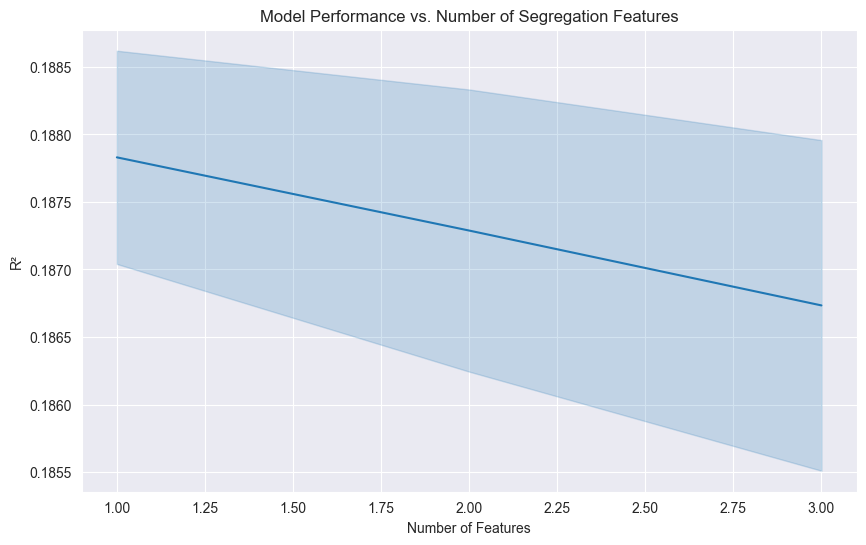

Best feature set: segregation[3.0],segregation[7.0],segregation[13.0]
Best R²: 0.1898


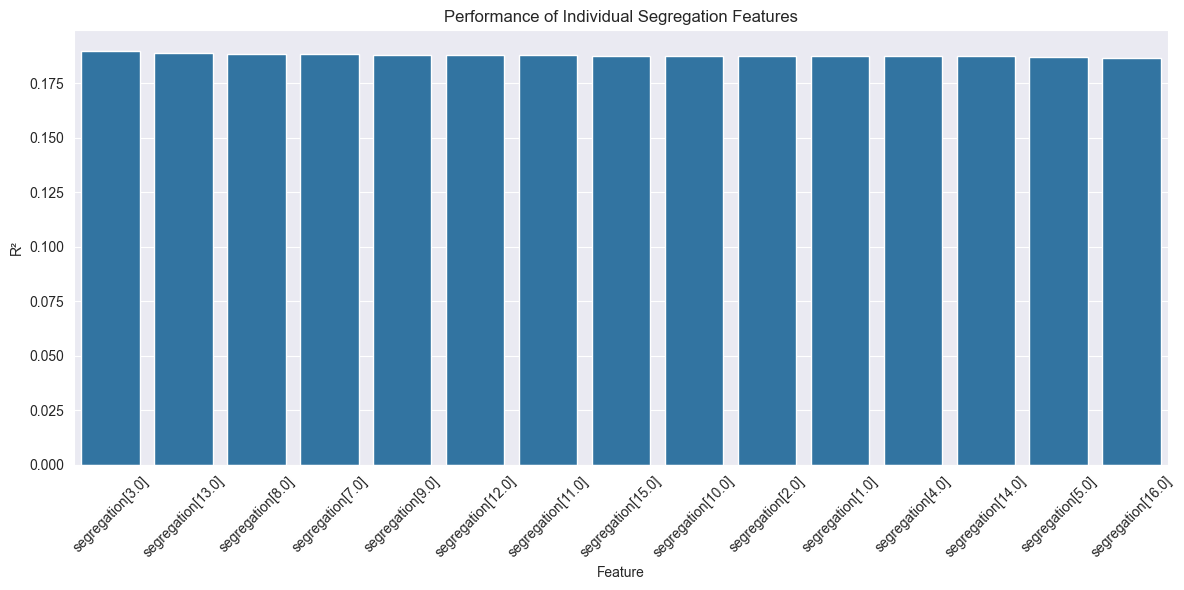

In [116]:
best_features = visualize_feature_selection_results(results_df)

In [118]:
best_segregation_set = segregation_baseline[['segregation[3.0]','segregation[7.0]','segregation[13.0]']]

In [119]:
features_ses_segregation_baseline = combine_data(combined_baseline_2, best_segregation_set)
results_no_network, models_no_network = run_cross_validation(features_ses_segregation_baseline, y_baseline_2,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.477
Partial eta squared: 0.190
R²: 0.190


In [122]:
# Test 1: Observations + SES vs Observations + SES + Segregation best set
test1 = f_test_r2(
    r2_reduced=0.188,
    r2_full=0.190,
    n=combined_baseline_2.shape[0],
    p_reduced=combined_baseline_2.shape[1] - 1,
    p_full=combined_baseline_2.shape[1] + 2,
)
print(f"Test 1 (Obs vs Obs+SES): F={test1['f_statistic']:.4f}, p={test1['p_value']:.4e}")
if test1['p_value'] < 0.05:
    print(f"The full model provides a statistically significant improvement over the reduced model.")
else:
    print("There is not enough evidence")

Test 1 (Obs vs Obs+SES): F=2.0255, p=1.0824e-01
There is not enough evidence


In [123]:
segregation_followup = compute_one_statistic(
    df_features=features_1_aligned,
    df_network=networks_aligned_followup_df,
    community_sizes=community_sizes,
    net_order=net_order,
    mode="segregation",
    stat_name="segregation"
)

100%|██████████| 2478/2478 [01:09<00:00, 35.90it/s]


In [124]:
features_ses_segregation_followup = combine_data(combined_followup_2, segregation_followup)
results_no_network, models_no_network = run_cross_validation(features_ses_segregation_followup, y_followup_2,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.443
Partial eta squared: 0.162
R²: 0.162


In [125]:
results_df = evaluate_feature_subsets(combined_followup_2, y_followup_2, segregation_followup, max_features=3)

Testing individual features...


100%|██████████| 15/15 [00:00<00:00, 20.20it/s]


Testing feature combinations...


105it [00:05, 20.21it/s]
455it [00:23, 19.36it/s]


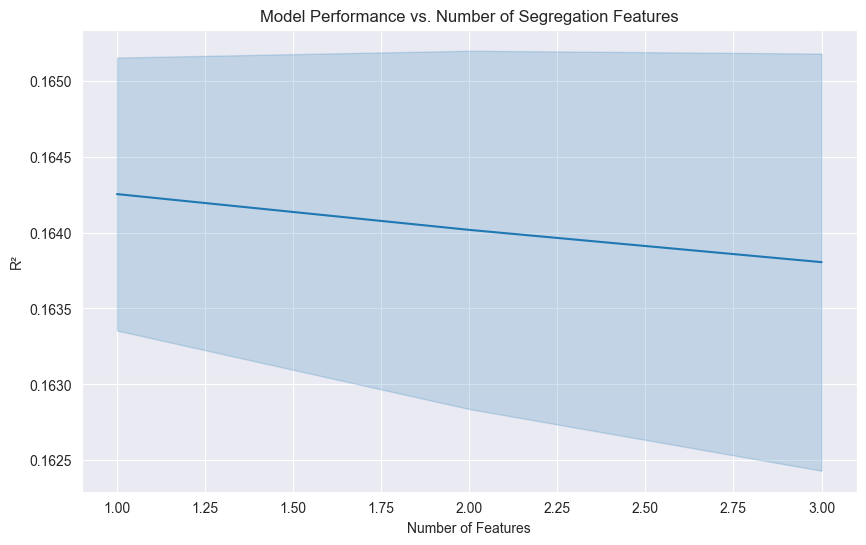

Best feature set: segregation[3.0],segregation[10.0],segregation[11.0]
Best R²: 0.1677


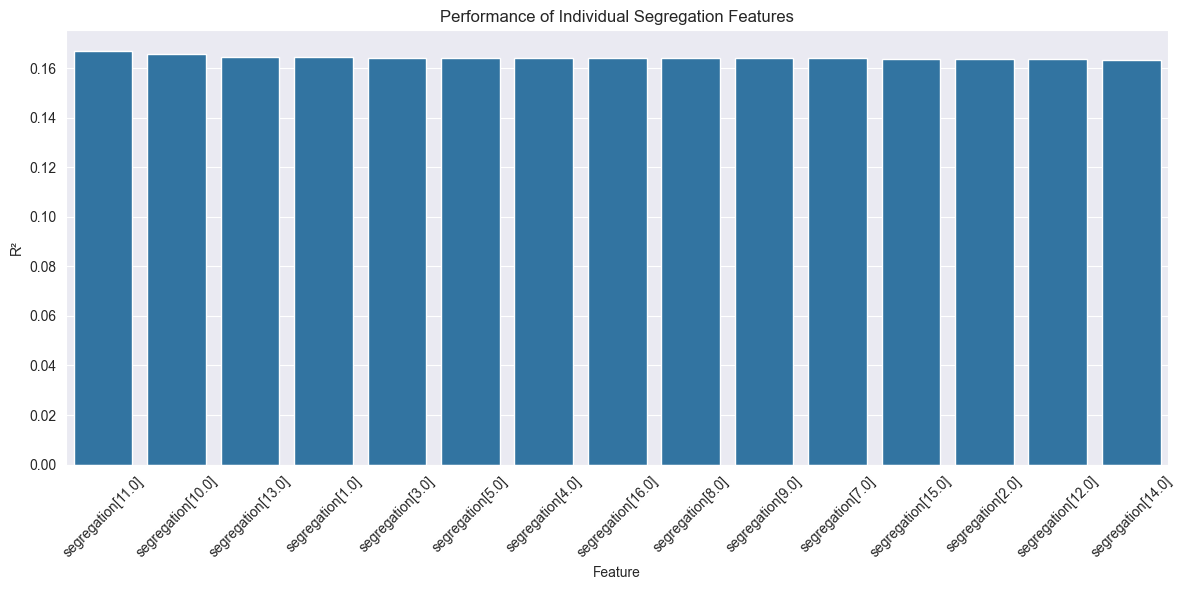

features        segregation[3.0],segregation[10.0],segregation...
num_features                                                    3
pearson_r                                                0.447961
r2                                                       0.167662
mse                                                      0.467685
Name: 334, dtype: object

In [126]:
visualize_feature_selection_results(results_df)

In [129]:
best_segregation_set = segregation_followup[['segregation[3.0]', 'segregation[10.0]', 'segregation[11.0]']]

In [130]:
features_ses_segregation_followup = combine_data(combined_followup_2, best_segregation_set)
results_no_network, models_no_network = run_cross_validation(features_ses_segregation_followup, y_followup_2,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.448
Partial eta squared: 0.168
R²: 0.168


In [131]:
# Test 2: Observations + SES vs Observations + SES + Segregation best set
test2 = f_test_r2(
    r2_reduced=0.165,
    r2_full=0.168,
    n=combined_followup_2.shape[0],
    p_reduced=combined_followup_2.shape[1] - 1,
    p_full=combined_followup_2.shape[1] + 2,
)
print(f"Test 2 (Obs vs Obs+SES): F={test2['f_statistic']:.4f}, p={test2['p_value']:.4e}")
if test2['p_value'] < 0.05:
    print(f"The full model provides a statistically significant improvement over the reduced model.")
else:
    print("There is not enough evidence")

Test 2 (Obs vs Obs+SES): F=2.9579, p=3.1216e-02
The full model provides a statistically significant improvement over the reduced model.


In [136]:
new_y_baseline = segregation_baseline['segregation[3.0]']

In [137]:
new_y_baseline

0       3.354894
1       3.522341
2       2.832126
3       3.640498
4       3.459631
          ...   
2473    3.264094
2474    3.660942
2475    3.368934
2476    3.397706
2477    3.234928
Name: segregation[3.0], Length: 2478, dtype: float64

In [138]:
results_no_network, models_no_network = run_cross_validation(combined_baseline_2, new_y_baseline,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: -0.058
Partial eta squared: -0.029
R²: -0.029


In [142]:
def compute_network_statistics_2(correlation_matrix, community_sizes, network_order, mode="all"):
    """
    Compute network-level statistics for each network in the connectivity matrix.

    Args:
        correlation_matrix: Symmetric connectivity matrix reordered by network
        community_sizes: List of sizes for each network
        network_order: Ordered list of network identifiers
        mode: Which statistics to compute ("all", "strengths", "connectivity", "segregation")

    Returns:
        DataFrame with network statistics for each network
    """
    network_stats = []
    cumulative_sizes = np.cumsum([0] + community_sizes)

    # Precompute only if needed
    if mode in ["all", "strengths"]:
        positive_strengths = compute_positive_strength(correlation_matrix)
        negative_strengths = compute_negative_strength(correlation_matrix)
        total_strengths = positive_strengths + negative_strengths

    for i, (network_id, size) in enumerate(zip(network_order, community_sizes)):
        start_idx = cumulative_sizes[i]
        end_idx = cumulative_sizes[i + 1]
        network_indices = list(range(start_idx, end_idx))

        stat_dict = {"network_id": network_id, "size": size}

        # Strengths
        if mode in ["all", "strengths"]:
            stat_dict.update({
                "avg_positive_strength": np.mean(positive_strengths[network_indices]),
                "avg_negative_strength": np.mean(negative_strengths[network_indices]),
                "avg_total_strength": np.mean(total_strengths[network_indices])
            })

        # Connectivity
        if mode in ["all", "connectivity", "segregation"]:
            network_matrix = correlation_matrix[np.ix_(network_indices, network_indices)]
            within_positive = np.sum(network_matrix[network_matrix > 0])
            within_negative = np.sum(np.abs(network_matrix[network_matrix < 0]))
            within_connections = size * (size - 1) / 2

            other_indices = [idx for idx in range(correlation_matrix.shape[0]) if idx not in network_indices]
            between_matrix = correlation_matrix[np.ix_(network_indices, other_indices)]
            between_positive = np.sum(between_matrix[between_matrix > 0])
            between_negative = np.sum(np.abs(between_matrix[between_matrix < 0]))
            between_connections = size * (correlation_matrix.shape[0] - size)

            stat_dict.update({
                "within_positive_connectivity": within_positive / within_connections if within_connections > 0 else 0,
                "within_negative_connectivity": within_negative / within_connections if within_connections > 0 else 0,
                "between_positive_connectivity": between_positive / between_connections if between_connections > 0 else 0,
                "between_negative_connectivity": between_negative / between_connections if between_connections > 0 else 0
            })

            # Segregation only if needed
            if mode in ["all", "segregation"]:
                avg_within = within_positive / within_connections if within_connections > 0 else np.nan
                avg_between = between_positive / between_connections if between_connections > 0 else np.nan

                if not np.isnan(avg_within) and not np.isnan(avg_between):
                    # Ratio-based segregation (your version)
                    segregation_ratio = avg_within / avg_between if avg_between > 0 else np.nan
                    # Difference-based segregation (literature version)
                    segregation_diff = (avg_within - avg_between) / avg_within if avg_within > 0 else np.nan
                else:
                    segregation_ratio, segregation_diff = np.nan, np.nan

                stat_dict["segregation_ratio"] = segregation_ratio
                stat_dict["segregation_diff"] = segregation_diff

        network_stats.append(stat_dict)

    return pd.DataFrame(network_stats)

In [143]:
def compute_one_statistic_2(df_features, df_network, community_sizes, net_order, mode, stat_name):
    result = []
    # Create subject-to-site mapping dictionary
    subject_site_map = df_features.set_index('Subject')['site_id_l'].to_dict()

    df_network['site_id_l'] = df_network['Subject'].map(subject_site_map)
    #df_network.fillna(0, inplace=True)

    for row in tqdm(df_network.itertuples(index=False), total=len(df_network)):
        subj_id = row.Subject
        site_id = row.site_id_l

        # Reconstruct matrix from flattened vector
        matrix_values = matrix_values = [v for k,v in row._asdict().items() if k not in ("Subject", "site_id_l")]
        corr_matrix = vector_to_symmetric_matrix(matrix_values, 418)

        # Compute stats
        network_stats = compute_network_statistics_2(corr_matrix, community_sizes, net_order, mode=mode)

        # Build one dictionary per subject
        row_dict = {"Subject": subj_id, "site_id_l": site_id}
        for _, stat_row in network_stats.iterrows():
            net_id = stat_row["network_id"]
            if stat_name in stat_row:
                row_dict[f"{stat_name}[{net_id}]"] = stat_row[stat_name]
        result.append(row_dict)
    return pd.DataFrame(result)

In [146]:
segregation_ratio_followup = compute_one_statistic_2(
    df_features=features_1_aligned,
    df_network=networks_aligned_followup_df,
    community_sizes=community_sizes,
    net_order=net_order,
    mode="segregation",
    stat_name="segregation_ratio"
)

100%|██████████| 2478/2478 [01:08<00:00, 36.10it/s]


In [147]:
segregation_ratio_followup.head()

,Subject,site_id_l,segregation_ratio[1.0],segregation_ratio[2.0],segregation_ratio[3.0],segregation_ratio[4.0],segregation_ratio[5.0],segregation_ratio[7.0],segregation_ratio[8.0],segregation_ratio[9.0],segregation_ratio[10.0],segregation_ratio[11.0],segregation_ratio[12.0],segregation_ratio[13.0],segregation_ratio[14.0],segregation_ratio[15.0],segregation_ratio[16.0]
0,NDARINV00CY2MDM,site20,2.377146,3.608000,3.429073,3.769751,3.004767,2.203309,3.558529,4.392775,3.270808,3.092700,2.789221,2.709454,2.618214,4.452076,2.421374
1,NDARINV00U4FTRU,site04,2.679662,4.209667,3.305061,4.245677,3.167072,2.384166,4.702205,17.423184,3.741852,3.089738,3.812125,2.425534,3.319339,11.454687,3.465319
2,NDARINV01AJ15N9,site16,2.714924,5.521429,3.029452,4.102286,2.952932,2.042508,4.790092,7.055470,3.477717,2.853764,3.190687,2.635544,2.536393,5.776752,3.316870
3,NDARINV01EN91PG,site19,2.462500,4.567372,3.770744,4.113343,2.572776,2.353984,3.957682,7.661305,3.329712,2.430159,3.415643,2.945402,3.391205,6.034700,2.242120
4,NDARINV01NAYMZH,site16,2.405506,4.924863,3.507637,4.253568,2.756554,2.217883,4.939120,10.412989,3.231110,2.866647,3.543177,2.210996,2.992603,5.046030,3.626323


In [148]:
features_ses_segregation_ratio_followup = combine_data(combined_followup_2, segregation_ratio_followup)
results_no_network, models_no_network = run_cross_validation(features_ses_segregation_ratio_followup, y_followup_2,
                                                             use_network=False)
print_cross_val_results(results_no_network)

Cross-validated Performance Metrics:
Average Pearson's r: 0.443
Partial eta squared: 0.162
R²: 0.162
